# Introduction
This notebook follows the process of land cover classification for measuring Biodiversity NetGain. This notebook will focus on image classification using the EuroSAT dataset (found on: https://github.com/phelber/eurosat).

## Problem Description:
Biodiversity offsetting is a system used to compensate for the impacts of development on the biodiversity. In the United Kingdom developers have to account for 10% net gain in biodiversity to get permission for development. In case they fail to meet this criterion, developers can compensate for the loss of biodiversity units by purchasing biodiversity offsets. Offset sites require sufficient preparation, which involves tasks like measuring the health of the habitat and identifying the species present within the habitat.

Currently, ecologists rely on conducting manual surveys of the habitat, which is time-consuming and requires trained professionals. With the introduction of mandatory net gain, ecologists started looking into the applicability of AI to automate some of the tasks. In ecological applications, machine learning models for plant classification and measuring plant health are abundant.

For this reason I have decided to focus on creating a model, that would be able to roughly determine the suitability of the habitat based on the satellite imagery. Land Cover Mapping provides information about land use and cover patterns. Satellite imagery is a cost efficient way to accurately map the cover patterns. Such data is relatively easy to access through the stallite's mission's site (ex Sentinel mission data avialable at: https://dataspace.copernicus.eu/explore-data/data-collections). Training machine learning models requires a high amount of data, which is not readily available. Satellite images have high resolution and require extensive pre-processing and labelling. On the other hand, manually creating datasets offers some degree of flexibility, as country specific datasets are rare. Software like QGIS offers machine learning plugins with pre-trained models, however there are several concerns about data privacy and the explainability of the model used, that might deter ecologists from fully trusting these methods. In general, Land Use Land Cover mapping is done on multispectral datasets containing hand applied masks, which the model is trained on through process known as image segmentation. Such datasets are rare and have a limited amount of data. One of the more common datasets is Landcover.ai (found on: https://landcover.ai.linuxpolska.com/), however it only has 4 classes compared to the EuroSAT with 10 classes.

This notebook will attempt to answer the following questions:
1. Is it possible to recreate the process of land cover mapping and classification using public datasets?
2. Will this method be reliable for accurate determining of potential offest sites?
3. Can landcover mapping be achievable through image classification?

## Approaches
After trying few different approaches including:
1. Creating a new dataset that would create additional folders for each class respective for train, test and validation. The code created by Daniel Bourke (https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb) shows an example how it can be done. In this approach he creates a 10% dataset
2. Using the following tutorial (https://www.tensorflow.org/tutorials/load_data/images) to create a custom input pipeline with limited number of images
3. Using the following approach by Nilesh Sonune (https://www.kaggle.com/code/nilesh789/land-cover-classification-with-eurosat-dataset#I.-Data-Exploration) to separate the images into train and test folders and then selecting the NUM_IMG to limit the amount of data for experimentation.

I have decided to use the third approach. The model I have set on using is ResNet50 trained on ImageNet and then finetuned. The initial models developed in the notebook I provided gave good results, however they were not easy to replicate.


# Preparing the workspace
This section involves the following:
* Mounting the google drive into `Google Colab`
* Unzipping the files where applicable
* Loading necessary libraries

In [1]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzipping the files
#!unzip "/content/drive/MyDrive/EuroSAT1.zip" -d "drive/MyDrive/EuroSAT"

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: drive/MyDrive/EuroSAT/2750/SeaLake/SeaLake_2206.jpg  
  inflating: drive/MyDrive/EuroSAT/2750/SeaLake/SeaLake_1313.jpg  
  inflating: drive/MyDrive/EuroSAT/2750/SeaLake/SeaLake_263.jpg  
  inflating: drive/MyDrive/EuroSAT/2750/SeaLake/SeaLake_967.jpg  
  inflating: drive/MyDrive/EuroSAT/2750/SeaLake/SeaLake_515.jpg  
  inflating: drive/MyDrive/EuroSAT/2750/SeaLake/SeaLake_1465.jpg  
  inflating: drive/MyDrive/EuroSAT/2750/SeaLake/SeaLake_1817.jpg  
  inflating: drive/MyDrive/EuroSAT/2750/SeaLake/SeaLake_2902.jpg  
  inflating: drive/MyDrive/EuroSAT/2750/SeaLake/SeaLake_2570.jpg  
  inflating: drive/MyDrive/EuroSAT/2750/SeaLake/SeaLake_1004.jpg  
  inflating: drive/MyDrive/EuroSAT/2750/SeaLake/SeaLake_174.jpg  
  inflating: drive/MyDrive/EuroSAT/2750/SeaLake/SeaLake_2111.jpg  
  inflating: drive/MyDrive/EuroSAT/2750/SeaLake/SeaLake_2388.jpg  
  inflating: drive/MyDrive/EuroSAT/2750/SeaLake/SeaLake_1948.jpg  
 

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
from tensorflow import keras
import random
import glob
import matplotlib.pyplot as plt
import PIL
import seaborn as sns

In [3]:
# Checking the tensorflow version and GPU avialability:
print ("TF version: ", tf.__version__)
print("GPU", "avialable" if tf.config.list_physical_devices("GPU") else "not available")

TF version:  2.17.0
GPU avialable


In [4]:
version_fn = getattr(tf.keras, "version", None)
print("TF Version: " + tf.__version__)
print("TF Keras Version: " + version_fn())

TF Version: 2.17.0
TF Keras Version: 3.4.1


# EuroSAT


Original dataset: https://github.com/phelber/EuroSAT

The dataset contains 27 000 images separated into 10 different classes:

0: AnnualCrop

1: Forest

2: HerbaceousVegetation

3: Highway

4: Industrial

5: Pasture

6: PermamentCrop

7: Residential

8: River

9: SeaLake

The data was collected using Sentinel-2 mission from several european countries, with the United Kingdom contributing to around 11% of total images (the highest contribution belonging to France-19%).

The code in this section is applied to the RGB dataset.

## Loading the data

1. Loading the data
2. Defining the parameters

In [3]:
df_path = "/content/drive/MyDrive/EuroSAT/2750/"

In [6]:
# Defining the parameters
BATCH_SIZE = 32
IMG_SHAPE = (64,64)
val_split = 0.2
rescale = 1.0/255

In [ ]:
# NUM_IMAGES = 3000 #@param {type:"slider", min:1000, max:27000, step:1000}

In [4]:
NUM_IMAGES = 7000

In [5]:
labels = os.listdir(df_path)
print(labels)

['SeaLake', 'PermanentCrop', 'River', 'AnnualCrop', 'HerbaceousVegetation', 'Industrial', 'Residential', 'Highway', 'Pasture', 'Forest']


## Data analysis

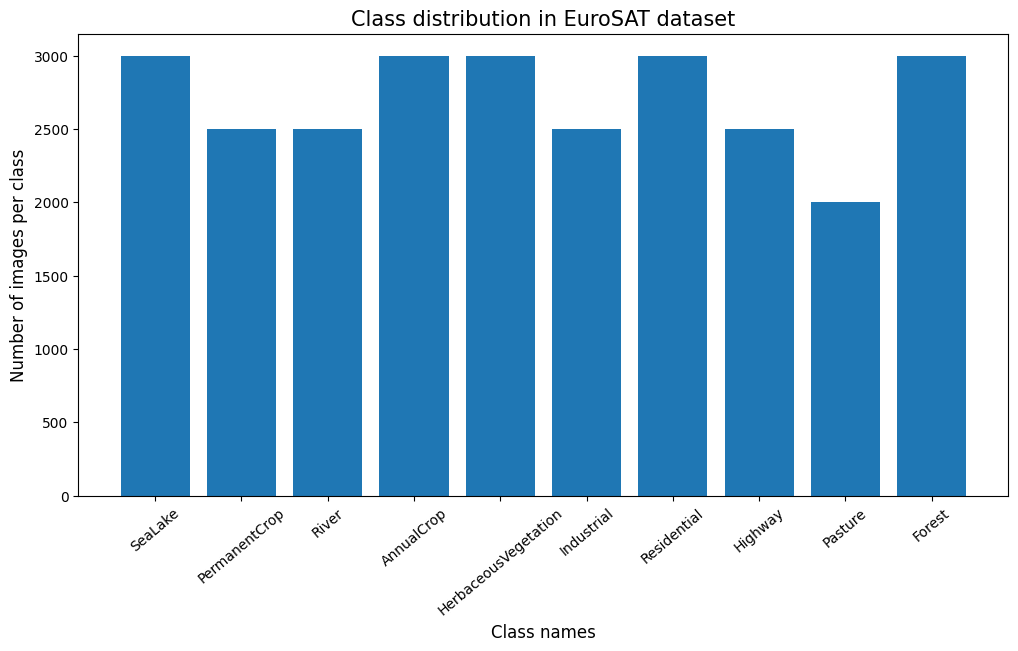

In [10]:
count_labels={}

for l in labels:
  count_labels[l] = len(os.listdir(os.path.join(df_path, l)))

plt.figure(figsize=(12,6))
plt.bar(range(len(count_labels)),list(count_labels.values()), align='center')
plt.xticks(range(len(count_labels)), list(count_labels.keys()), fontsize=10, rotation=40)
plt.xlabel('Class names', fontsize=12)
plt.ylabel('Number of images per class', fontsize=12)
plt.title('Class distribution in EuroSAT dataset', fontsize=15)
plt.show()

In [11]:
# Displaying the images
from PIL import Image
from pathlib import Path
import pathlib

base_dir = pathlib.Path( "/content/drive/MyDrive/EuroSAT/2750/")
def display_images(base_dir):
  class_labels = sorted(os.listdir(base_dir))[:10] #focuses on the first 10 classes and omits json file

  fig, axes = plt.subplots(2, 5, figsize=(10,4))
  axes=axes.flatten() # treats the axes as array

  for idx, class_label in enumerate(class_labels):
    class_dir=os.path.join(base_dir, class_label)
    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith('.jpg')] # omits files that are not .jpg

    if not image_files:
      continue

    img_path = os.path.join(class_dir, image_files[0])
    img = Image.open(img_path)

    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(class_label, fontsize=10)
  plt.tight_layout()
  plt.show()


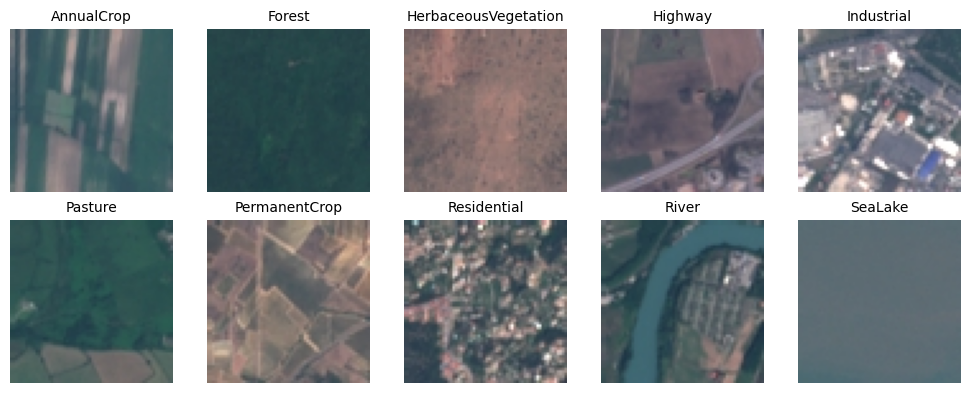

In [12]:
display_images(base_dir)

Classes are somewhat balanced with the exception of `Pasture`. Looking at the images it is also easy to see that certain classes can be confused with each other. Now the dataset is quite big with 27000 images belonging to 10 classes. Experimenting on such a big dataset is going to take a long time. As mentioned at the begining I have tried several approaches and decided to create two new datasets for the best efficiency. One with all images split into train and test folders using the method developed by Nilesh Sonune (https://www.kaggle.com/code/nilesh789/land-cover-classification-with-eurosat-dataset#I.-Data-Exploration) since he performs it on the same dataset. The second dataset will contain the 3000 images separated into train and test sets using the adjusted method.

## Creating new datasets

In [6]:
import re #regular operations module
import shutil # high-level operations on files
from tqdm import tqdm #progress bar

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

In [8]:
# First create the full image dataset
TRAIN_DIR_F = "/content/drive/MyDrive/EuroSAT/FullDataset/training"
TEST_DIR_F = "/content/drive/MyDrive/EuroSAT/FullDataset/testing"
NUM_CLASSES = len(labels)

In [ ]:
for path in (TRAIN_DIR_F, TEST_DIR_F):
  if not os.path.exists(path):
    os.mkdir(path)
for l in labels:
  if not os.path.exists(os.path.join(TRAIN_DIR_F, l)):
    os.mkdir(os.path.join(TRAIN_DIR_F, l))
  if not os.path.exists(os.path.join(TEST_DIR_F, l)):
    os.mkdir(os.path.join(TEST_DIR_F, l))

In [ ]:
# map the images to the corresponding class label in data

data = {}
for l in labels:
  for img in os.listdir(df_path+'/'+l):
    data.update({os.path.join(df_path, l, img):l})
X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=val_split, random_state=42)

# Splitting the list of image paths
for train_idx, test_idx in split.split(X,y):
  train_paths = X[train_idx]
  test_paths = X[test_idx]

  #defining new paths for each image depending on training/testing
  new_train_pf = [re.sub("/content/drive/MyDrive/EuroSAT/2750", "/content/drive/MyDrive/EuroSAT/FullDataset/training", i) for i in train_paths]
  new_test_pf = [re.sub("/content/drive/MyDrive/EuroSAT/2750", "/content/drive/MyDrive/EuroSAT/FullDataset/testing", i) for i in test_paths]

  train_path_map = list((zip(train_paths, new_train_pf)))
  test_path_map = list((zip(test_paths, new_test_pf)))

  # moving the files
  print("moving training files..")
  for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

  print("moving testing files..")
  for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

moving training files..


100%|██████████| 21600/21600 [2:06:05<00:00,  2.86it/s]


moving testing files..


100%|██████████| 5400/5400 [30:46<00:00,  2.92it/s]


In [9]:
# Creating the same process with 3250 images
TRAIN_DIR = "/content/drive/MyDrive/EuroSAT/LimitedDataset/training"
TEST_DIR = "/content/drive/MyDrive/EuroSAT/LimitedDataset/testing"
NUM_CLASSES = len(labels)

In [ ]:
for path in (TRAIN_DIR, TEST_DIR):
  if not os.path.exists(path):
    os.mkdir(path)
for l in labels:
  if not os.path.exists(os.path.join(TRAIN_DIR, l)):
    os.mkdir(os.path.join(TRAIN_DIR, l))
  if not os.path.exists(os.path.join(TEST_DIR, l)):
    os.mkdir(os.path.join(TEST_DIR, l))

In [ ]:
train_img_count = int(NUM_IMAGES * 0.8)
test_img_count = NUM_IMAGES - train_img_count

In [10]:
from sklearn.model_selection import train_test_split

In [ ]:
# Creating a limited dataset:
datal = {}
for l in labels:
  for img in os.listdir(df_path+'/'+l):
    datal.update({os.path.join(df_path, l, img):l})

X = pd.Series(list(datal.keys()))
y = pd.get_dummies(pd.Series(datal.values()))


# Limit the dataset to NUM_IMAGES while maintaining class balance
_, X_limited, _, y_limited = train_test_split(X, y, stratify=y, train_size=NUM_IMAGES, random_state=42)

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_limited, y_limited, stratify=y_limited, train_size=train_img_count, test_size=test_img_count, random_state=42)


  #defining new paths for each image depending on training/testing
new_train_path = [re.sub("/content/drive/MyDrive/EuroSAT/2750", "/content/drive/MyDrive/EuroSAT/LimitedDataset/training", i) for i in X_train]
new_test_path = [re.sub("/content/drive/MyDrive/EuroSAT/2750", "/content/drive/MyDrive/EuroSAT/LimitedDataset/testing", i) for i in X_test]

train_path_map = list((zip(X_train, new_train_path)))
test_path_map = list((zip(X_test, new_test_path)))

  # moving the files

# print("moving training files..")
# for i in tqdm(train_path_map):
#         if not os.path.exists(i[1]):
#             if not os.path.exists(re.sub('training', 'testing', i[1])):
#                 shutil.copy(i[0], i[1])

# print("moving testing files..")
# for i in tqdm(test_path_map):
#         if not os.path.exists(i[1]):
#             if not os.path.exists(re.sub('training', 'testing', i[1])):
#                 shutil.copy(i[0], i[1])

def moving_files(path_map):
  for src,data in tqdm(path_map):
    os.makedirs(os.path.dirname(data), exist_ok=True)
    if not os.path.exists(data):
      shutil.copy(src, data)

In [ ]:
print("Moving training files...")
moving_files(train_path_map)
print("Moving testing files...")
moving_files(test_path_map)

Moving training files...


100%|██████████| 5600/5600 [36:07<00:00,  2.58it/s]


Moving testing files...


100%|██████████| 1400/1400 [08:53<00:00,  2.62it/s]


In [ ]:
def class_distriution(y_data, title):

  count_labels = y_data.value_counts().to_dict()
  plt.figure(figsize=(12,6))
  plt.bar(range(len(count_labels)),list(count_labels.values()), align='center')
  plt.xticks(range(len(count_labels)), list(count_labels.keys()), fontsize=10, rotation=40)
  plt.xlabel('Class names', fontsize=12)
  plt.ylabel('Number of images per class', fontsize=12)
  plt.show()

In [ ]:
y_train_decoded = y_train.idxmax(axis=1)
y_test_decoded = y_test.idxmax(axis=1)

AttributeError: 'list' object has no attribute 'idxmax'

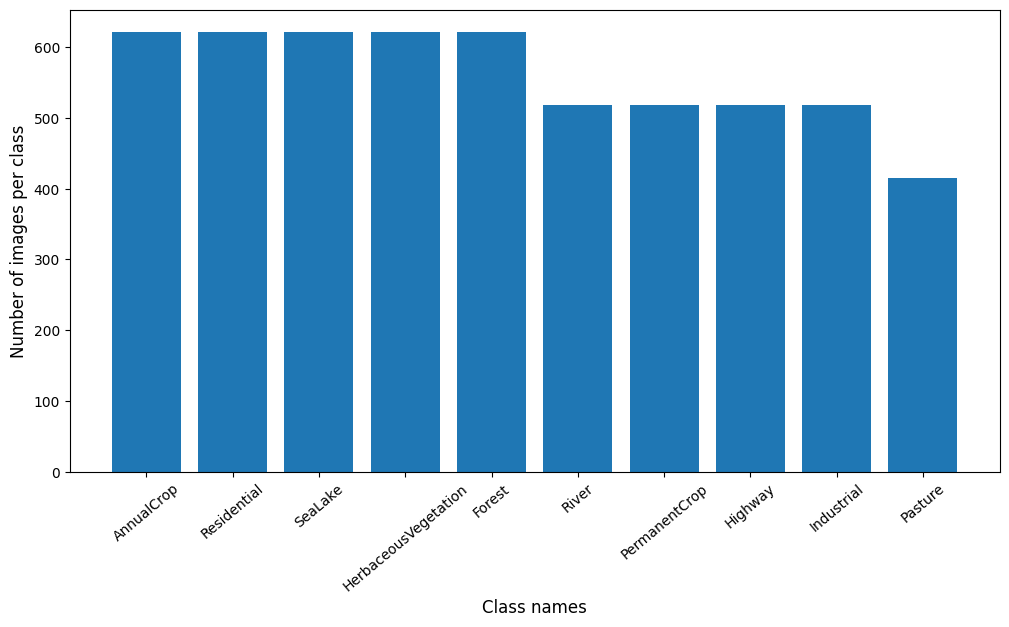

In [ ]:
class_distriution(y_train_decoded, 'Class Distribution in training set: ')

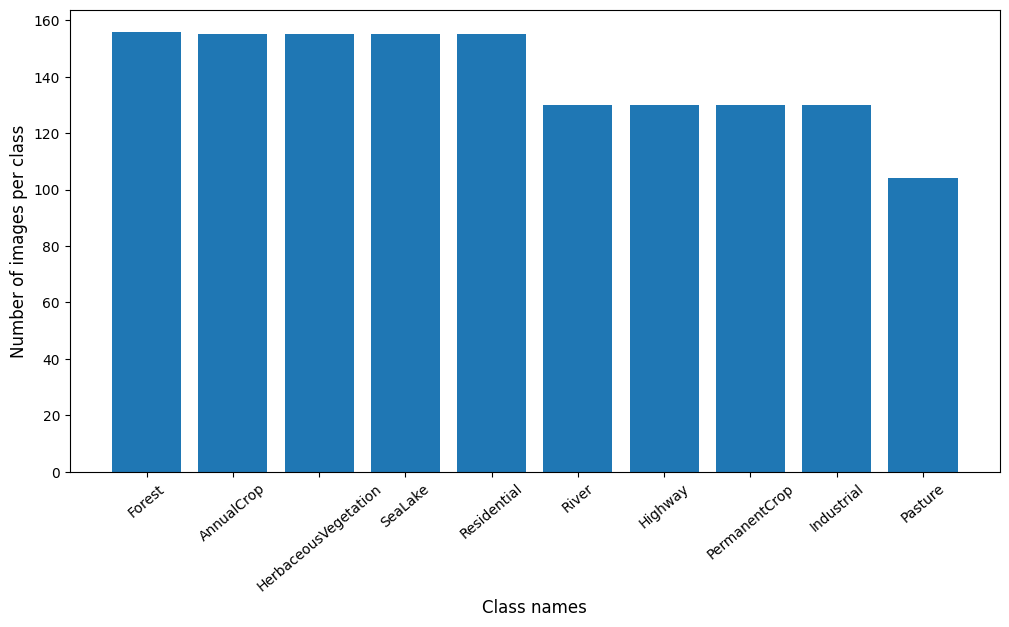

In [ ]:
class_distriution(y_test_decoded, 'Class Distribution in testing set: ')

In [ ]:
def image_label(directory):
  image_paths=[]
  labels=[]
  for label in os.listdir(directory):
    label_path = os.path.join(directory,label)
    if os.path.isdir(label_path):
      for image_file in os.listdir(label_path):
        img_path = os.path.join(label_path, image_file)
        image_paths.append(img_path)
        labels.append(label)
    return image_paths,labels
train_images, y_train = image_label(TRAIN_DIR)
test_images, y_test = image_label(TEST_DIR)
print("Take a look at labels:")
for img, label in zip(test_images[:1000], y_test[:1000]):
  print(f"Image: {img}, Label: {label}")

Take a look at labels:
Image: /content/drive/MyDrive/EuroSAT/LimitedDataset/testing/SeaLake/SeaLake_62.jpg, Label: SeaLake
Image: /content/drive/MyDrive/EuroSAT/LimitedDataset/testing/SeaLake/SeaLake_2848.jpg, Label: SeaLake
Image: /content/drive/MyDrive/EuroSAT/LimitedDataset/testing/SeaLake/SeaLake_2316.jpg, Label: SeaLake
Image: /content/drive/MyDrive/EuroSAT/LimitedDataset/testing/SeaLake/SeaLake_183.jpg, Label: SeaLake
Image: /content/drive/MyDrive/EuroSAT/LimitedDataset/testing/SeaLake/SeaLake_2485.jpg, Label: SeaLake
Image: /content/drive/MyDrive/EuroSAT/LimitedDataset/testing/SeaLake/SeaLake_1075.jpg, Label: SeaLake
Image: /content/drive/MyDrive/EuroSAT/LimitedDataset/testing/SeaLake/SeaLake_496.jpg, Label: SeaLake
Image: /content/drive/MyDrive/EuroSAT/LimitedDataset/testing/SeaLake/SeaLake_1436.jpg, Label: SeaLake
Image: /content/drive/MyDrive/EuroSAT/LimitedDataset/testing/SeaLake/SeaLake_1976.jpg, Label: SeaLake
Image: /content/drive/MyDrive/EuroSAT/LimitedDataset/testing/Se

In [11]:
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/EuroSAT/LimitedDataset"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 3 directories and 0 images in /content/drive/MyDrive/EuroSAT/LimitedDataset
There are 0 directories and 0 images in /content/drive/MyDrive/EuroSAT/LimitedDataset/.ipynb_checkpoints
There are 10 directories and 0 images in /content/drive/MyDrive/EuroSAT/LimitedDataset/training
There are 0 directories and 622 images in /content/drive/MyDrive/EuroSAT/LimitedDataset/training/SeaLake
There are 0 directories and 519 images in /content/drive/MyDrive/EuroSAT/LimitedDataset/training/PermanentCrop
There are 0 directories and 519 images in /content/drive/MyDrive/EuroSAT/LimitedDataset/training/River
There are 0 directories and 622 images in /content/drive/MyDrive/EuroSAT/LimitedDataset/training/AnnualCrop
There are 0 directories and 622 images in /content/drive/MyDrive/EuroSAT/LimitedDataset/training/HerbaceousVegetation
There are 0 directories and 518 images in /content/drive/MyDrive/EuroSAT/LimitedDataset/training/Industrial
There are 0 directories and 622 images in /content/drive/MyD

# Limited Dataset: ImageDataGenerator
Now its time to prepare the test and train data and make it ready for experimenting

## Preparing the data

### No augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
batch_size=32
IMG_SIZE = (224,224)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255. )
test_datagen = ImageDataGenerator(rescale=1/255.)
train_data_limited = train_datagen.flow_from_directory(TRAIN_DIR,
                                                        target_size=IMG_SIZE,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        shuffle=True,
                                                        seed=42,

                                                       )
test_data_limited = test_datagen.flow_from_directory(TEST_DIR,
                                                        target_size=IMG_SIZE,
                                                        class_mode='categorical',
                                                        shuffle=False,
                                                        batch_size=batch_size)
#, horizontal_flip=True, vertical_flip=True, rotation_range=60,shear_range=0.2,zoom_range=0.1, height_shift_range=0.1, width_shift_range=0.1

Found 5600 images belonging to 10 classes.
Found 1400 images belonging to 10 classes.


In [ ]:
train_dataset1 = train_data_limited
test_dataset1 = test_data_limited
# steps_per_epoch = len(train_data_limited1)

### With augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255., horizontal_flip=True, vertical_flip=True, rotation_range=60,shear_range=0.2,zoom_range=0.1, height_shift_range=0.1, width_shift_range=0.1)
test_datagen = ImageDataGenerator(rescale=1/255.)
train_data_limitedA = train_datagen.flow_from_directory(TRAIN_DIR,
                                                        target_size=IMG_SIZE,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        shuffle=True,
                                                        seed=42,

                                                       )
test_data_limitedA = test_datagen.flow_from_directory(TEST_DIR,
                                                        target_size=IMG_SIZE,
                                                        class_mode='categorical',
                                                        shuffle=False,
                                                        batch_size=batch_size)


Found 5600 images belonging to 10 classes.
Found 1400 images belonging to 10 classes.


In [ ]:
train_datasetA = train_data_limitedA
test_datasetA = test_data_limitedA

## Building the model using keras API
I will be using the ResNet50 model trained on ImageNet

In [12]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Reshape, MaxPooling2D, Rescaling
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import datetime

In [13]:
batch_size=32
IMG_SIZE = (224,224)

In [14]:
# Creating a tensorflow callback function (https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb)
def tensorflow_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving the log files to: {log_dir}')
  return tensorboard_callback

In [15]:
base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [16]:
base_model.trainable=False

In [ ]:
# train_dataset = train_data_limited
# test_dataset = test_data_limited
# steps_per_epoch = len(train_data_limited) // batch_size
# validation_steps = len(test_data_limited) // batch_size

### No augmentation

In [ ]:
# Building the model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# Normalising the data
# x = tf.keras.layers.Rescaling(1./255)(inputs)

x = base_model(inputs)
print(f"Shape after base_model: {x.shape}")

# Average pool the outputs to reduce the computations
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling: {x.shape}")

# Add the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_02L1 = tf.keras.Model(inputs, outputs)

#Compiling the model
model_02L1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_02L1 = model_02L1.fit(train_dataset1,epochs=5, callbacks=[tensorflow_callback('transfer_learning', "limiteddataset_resnet50_02L1")]).history

Shape after base_model: (None, 7, 7, 2048)
Shape after Global Average Pooling: (None, 2048)
Saving the log files to: transfer_learning/limiteddataset_resnet50_02L1/20240911-151115
Epoch 1/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.6064 - loss: 1.2307
Epoch 2/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9064 - loss: 0.3211
Epoch 3/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.9314 - loss: 0.2325
Epoch 4/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9507 - loss: 0.1817
Epoch 5/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.9594 - loss: 0.1605


In [ ]:
model_02L1.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,626,272 (90.13 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 40,982 (160.09 KB)

In [ ]:
# Building the model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# Normalising the data
# x = tf.keras.layers.Rescaling(1./255)(inputs)

x = base_model(inputs)
print(f"Shape after base_model: {x.shape}")

# Average pool the outputs to reduce the computations
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling: {x.shape}")

# Add the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_03L1 = tf.keras.Model(inputs, outputs)

#Compiling the model
model_03L1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_03L1 = model_03L1.fit(train_dataset1,epochs=5, validation_data=test_dataset1, callbacks=[tensorflow_callback('transfer_learning', "limiteddataset_resnet50_02L1")]).history

Shape after base_model: (None, 7, 7, 2048)
Shape after Global Average Pooling: (None, 2048)
Saving the log files to: transfer_learning/limiteddataset_resnet50_02L1/20240911-151246
Epoch 1/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - accuracy: 0.6784 - loss: 1.0944 - val_accuracy: 0.8700 - val_loss: 0.4103
Epoch 2/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.9127 - loss: 0.3114 - val_accuracy: 0.8864 - val_loss: 0.3294
Epoch 3/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.9386 - loss: 0.2237 - val_accuracy: 0.8964 - val_loss: 0.3078
Epoch 4/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.9439 - loss: 0.1896 - val_accuracy: 0.9021 - val_loss: 0.2771
Epoch 5/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.9623 - loss: 0.1494 - val_accuracy: 0.9064 - val_loss: 0.2654


In [ ]:
# Building the model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# Normalising the data
# x = tf.keras.layers.Rescaling(1./255)(inputs)

x = base_model(inputs)
print(f"Shape after base_model: {x.shape}")

# Average pool the outputs to reduce the computations
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling: {x.shape}")

# Add the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_03L2 = tf.keras.Model(inputs, outputs)

#Compiling the model
model_03L2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_03L2 = model_03L2.fit(train_dataset1,epochs=10, validation_data=test_dataset1, callbacks=[tensorflow_callback('transfer_learning', "limiteddataset_resnet50_03L2")]).history

Shape after base_model: (None, 7, 7, 2048)
Shape after Global Average Pooling: (None, 2048)
Saving the log files to: transfer_learning/limiteddataset_resnet50_03L2/20240911-172204
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 32s 136ms/step - accuracy: 0.6678 - loss: 1.1052 - val_accuracy: 0.8643 - val_loss: 0.4004
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.9229 - loss: 0.2981 - val_accuracy: 0.8886 - val_loss: 0.3213
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - accuracy: 0.9397 - loss: 0.2181 - val_accuracy: 0.8979 - val_loss: 0.2935
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.9576 - loss: 0.1732 - val_accuracy: 0.9050 - val_loss: 0.2755
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.9635 - loss: 0.1462 - val_accuracy: 0.9050 - val_loss: 0.2671
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.9654 - loss: 0.1317 - val_accuracy: 0.9086 - val_loss: 0.2543
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━

In [ ]:
def create_model(input_shape: tuple[int,int,int] = (224,224,3), output_shape: int =10, learning_rate: float=0.001, training: bool=False) -> tf.keras.Model:

  #Create base model:
  base_model = tf.keras.applications.ResNet50V2(include_top=False)
  base_model.trainable=training
  # Model inputs and outputs with data augmentation
  inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
  #x = data_augmentation(inputs)
  #x = base_model(x, training=False)
  x = base_model(inputs)
  x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
  x = tf.keras.layers.Dense(units=1025, activation="relu")(x)
  x = tf.keras.layers.Dropout(0.2)(x) # to prevent overfitting

  outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)
  model = tf.keras.Model(inputs, outputs)

  #Compile the model:
  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])

  return model

In [ ]:
model_3 = create_model()

In [ ]:
history1L1 = model_3.fit(train_dataset1, epochs=10, validation_data=test_dataset1, callbacks=[tensorflow_callback('transfer_learning', "limiteddataset_resnet50_1L1")]).history

Saving the log files to: transfer_learning/limiteddataset_resnet50_1L1/20240911-161657
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 33s 139ms/step - accuracy: 0.7651 - loss: 0.6711 - val_accuracy: 0.9036 - val_loss: 0.3043
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.9368 - loss: 0.1815 - val_accuracy: 0.9029 - val_loss: 0.3086
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.9626 - loss: 0.1053 - val_accuracy: 0.9129 - val_loss: 0.3034
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.9774 - loss: 0.0711 - val_accuracy: 0.9114 - val_loss: 0.3162
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.9766 - loss: 0.0675 - val_accuracy: 0.9214 - val_loss: 0.2834
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - accuracy: 0.9927 - loss: 0.0312 - val_accuracy: 0.9171 - val_loss: 0.3405
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.9873 - loss: 0.0317 - val_accuracy: 0.8936 - val_loss: 0.4

### With augmentation

In [ ]:
# Building the model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# Normalising the data
# x = tf.keras.layers.Rescaling(1./255)(inputs)

x = base_model(inputs)
print(f"Shape after base_model: {x.shape}")

# Average pool the outputs to reduce the computations
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling: {x.shape}")

# Add the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_01L2 = tf.keras.Model(inputs, outputs)

#Compiling the model
model_01L2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_01L2 = model_01L2.fit(train_datasetA,epochs=5, validation_data=test_datasetA, callbacks=[tensorflow_callback('transfer_learning', "limiteddataset_resnet50_02L2")]).history

Shape after base_model: (None, 7, 7, 2048)
Shape after Global Average Pooling: (None, 2048)
Saving the log files to: transfer_learning/limiteddataset_resnet50_02L2/20240911-145643
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 81s 408ms/step - accuracy: 0.5663 - loss: 1.3388 - val_accuracy: 0.8393 - val_loss: 0.5288
Epoch 2/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 380ms/step - accuracy: 0.8693 - loss: 0.4408 - val_accuracy: 0.8579 - val_loss: 0.4103
Epoch 3/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 380ms/step - accuracy: 0.8924 - loss: 0.3435 - val_accuracy: 0.8693 - val_loss: 0.3598
Epoch 4/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 379ms/step - accuracy: 0.8995 - loss: 0.3070 - val_accuracy: 0.8850 - val_loss: 0.3262
Epoch 5/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 379ms/step - accuracy: 0.9019 - loss: 0.3024 - val_accuracy: 0.8900 - val_loss: 0.2991


In [ ]:
# Building the model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# Normalising the data
# x = tf.keras.layers.Rescaling(1./255)(inputs)

x = base_model(inputs)
print(f"Shape after base_model: {x.shape}")

# Average pool the outputs to reduce the computations
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling: {x.shape}")

# Add the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_01L3 = tf.keras.Model(inputs, outputs)

#Compiling the model
model_01L3.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_01L3 = model_01L3.fit(train_datasetA,epochs=10, validation_data=test_datasetA, callbacks=[tensorflow_callback('transfer_learning', "limiteddataset_resnet50_02L2")]).history

Shape after base_model: (None, 7, 7, 2048)
Shape after Global Average Pooling: (None, 2048)
Saving the log files to: transfer_learning/limiteddataset_resnet50_02L2/20240911-172739
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 81s 407ms/step - accuracy: 0.5894 - loss: 1.3064 - val_accuracy: 0.8150 - val_loss: 0.5702
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 71s 387ms/step - accuracy: 0.8652 - loss: 0.4500 - val_accuracy: 0.8729 - val_loss: 0.4173
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 70s 384ms/step - accuracy: 0.8820 - loss: 0.3704 - val_accuracy: 0.8843 - val_loss: 0.3552
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 70s 383ms/step - accuracy: 0.8865 - loss: 0.3372 - val_accuracy: 0.8807 - val_loss: 0.3524
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 381ms/step - accuracy: 0.9002 - loss: 0.3071 - val_accuracy: 0.8993 - val_loss: 0.3075
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 70s 385ms/step - accuracy: 0.9042 - loss: 0.2808 - val_accuracy: 0.8964 - val_loss: 0.3000
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━

In [ ]:
model_2 = create_model(training=True)

In [ ]:
history1L2 = model_2.fit(train_datasetA, epochs=10, validation_data=test_datasetA, callbacks=[tensorflow_callback('transfer_learning', "limiteddataset_resnet50_1L2")]).history

Saving the log files to: transfer_learning/limiteddataset_resnet50_1L2/20240911-153321
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 377ms/step - accuracy: 0.8173 - loss: 0.8083 - val_accuracy: 0.9079 - val_loss: 0.3198
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 380ms/step - accuracy: 0.8863 - loss: 0.3309 - val_accuracy: 0.9129 - val_loss: 0.2760
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 377ms/step - accuracy: 0.9051 - loss: 0.2834 - val_accuracy: 0.9136 - val_loss: 0.2645
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 380ms/step - accuracy: 0.9090 - loss: 0.2565 - val_accuracy: 0.9129 - val_loss: 0.2642
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 379ms/step - accuracy: 0.9022 - loss: 0.2612 - val_accuracy: 0.9164 - val_loss: 0.2665
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 378ms/step - accuracy: 0.9080 - loss: 0.2723 - val_accuracy: 0.9243 - val_loss: 0.2651
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 378ms/step - accuracy: 0.9215 - loss: 0.2298 - val_accuracy: 0.9236 - val_loss: 0.2

In [ ]:
def create_model(input_shape: tuple[int,int,int] = (224,224,3), output_shape: int =10, learning_rate: float=0.001, training: bool=False) -> tf.keras.Model:

  #Create base model:
  base_model = tf.keras.applications.ResNet50V2(include_top=False)
  base_model.trainable=training
  # Model inputs and outputs with data augmentation
  inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
  #x = data_augmentation(inputs)
  #x = base_model(x, training=False)
  x = base_model(inputs)
  x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
  # x = tf.keras.layers.Dense(units=1025, activation="relu")(x)
  # x = tf.keras.layers.Dropout(0.2)(x) # to prevent overfitting

  outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)
  model = tf.keras.Model(inputs, outputs)

  #Compile the model:
  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])

  return model

In [ ]:
model_4 = create_model(training=False)

In [ ]:
history4_NoAUG = model_4.fit(train_dataset1, epochs=10, validation_data=test_dataset1, callbacks=[tensorflow_callback('transfer_learning', "limiteddataset_resnet50_4_NoAUG")]).history

Saving the log files to: transfer_learning/limiteddataset_resnet50_4_NoAUG/20240911-175056
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 33s 142ms/step - accuracy: 0.6536 - loss: 1.1322 - val_accuracy: 0.8650 - val_loss: 0.4154
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.9050 - loss: 0.3234 - val_accuracy: 0.8914 - val_loss: 0.3223
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.9353 - loss: 0.2223 - val_accuracy: 0.9000 - val_loss: 0.2927
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.9485 - loss: 0.1839 - val_accuracy: 0.9021 - val_loss: 0.2785
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.9585 - loss: 0.1494 - val_accuracy: 0.9093 - val_loss: 0.2712
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.9704 - loss: 0.1241 - val_accuracy: 0.9129 - val_loss: 0.2572
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.9696 - loss: 0.1217 - val_accuracy: 0.9150 - val_loss:

In [ ]:
history4_AUG = model_4.fit(train_datasetA, epochs=10, validation_data=test_datasetA, callbacks=[tensorflow_callback('transfer_learning', "limiteddataset_resnet50_4AUG")])

Saving the log files to: transfer_learning/limiteddataset_resnet50_4AUG/20240911-193856
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 80s 404ms/step - accuracy: 0.5638 - loss: 1.3205 - val_accuracy: 0.8229 - val_loss: 0.5423
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 379ms/step - accuracy: 0.8669 - loss: 0.4386 - val_accuracy: 0.8771 - val_loss: 0.4083
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 381ms/step - accuracy: 0.8855 - loss: 0.3649 - val_accuracy: 0.8836 - val_loss: 0.3489
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 378ms/step - accuracy: 0.8850 - loss: 0.3420 - val_accuracy: 0.8879 - val_loss: 0.3355
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 68s 375ms/step - accuracy: 0.9043 - loss: 0.2981 - val_accuracy: 0.8964 - val_loss: 0.3113
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 377ms/step - accuracy: 0.9034 - loss: 0.2884 - val_accuracy: 0.9014 - val_loss: 0.2939
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 379ms/step - accuracy: 0.9219 - loss: 0.2510 - val_accuracy: 0.8986 - val_loss: 0.

## Model Evaluation

This section will focus on evaluating each model through generating classification report, plotting confusion matrix and plotting the loss curves.

In [ ]:
resultsL_IDG_NOAG_1 = model_03L1.evaluate(test_dataset1)
resultsL_IDG_NOAG_1

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.9135 - loss: 0.2736


[0.265388548374176, 0.9064285755157471]

In [ ]:
resultsL_IDGNOAG_2 = model_3.evaluate(test_dataset1)
resultsL_IDGNOAG_2

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.8886 - loss: 0.6063


[0.4414229393005371, 0.9078571200370789]

In [ ]:
resultsL_IDGNOAG_2 = model_03L2.evaluate(test_dataset1)
resultsL_IDGNOAG_2

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9157 - loss: 0.2729


[0.2467527538537979, 0.9142857193946838]

In [ ]:
resultsL_IDGNOAG_4 = model_4.evaluate(test_dataset1)
resultsL_IDGNOAG_4

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9172 - loss: 0.2724


[0.2483459860086441, 0.9150000214576721]

In [ ]:
resultsL_IDG_AG_1 = model_01L2.evaluate(test_datasetA)
resultsL_IDG_AG_1


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.8863 - loss: 0.3210


[0.2990964353084564, 0.8899999856948853]

In [ ]:
resultsL_IDG_AG_2 = model_2.evaluate(test_datasetA)
resultsL_IDG_AG_2

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.9244 - loss: 0.2544


[0.25244832038879395, 0.920714259147644]

In [ ]:
resultsL_IDG_AG_3 = model_01L3.evaluate(test_datasetA)
resultsL_IDG_AG_3

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9131 - loss: 0.2836


[0.2755444645881653, 0.9085714221000671]

In [ ]:
resultsL_IDG_AG_4 = model_4.evaluate(test_datasetA)
resultsL_IDG_AG_4

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.9163 - loss: 0.2723


[0.2603464424610138, 0.9171428680419922]

### No augmentation

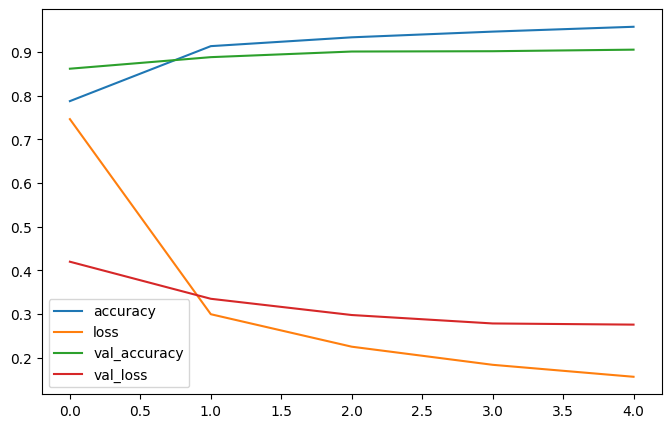

In [ ]:
pd.DataFrame(history_03L1).plot(figsize=(8,5))
plt.show()

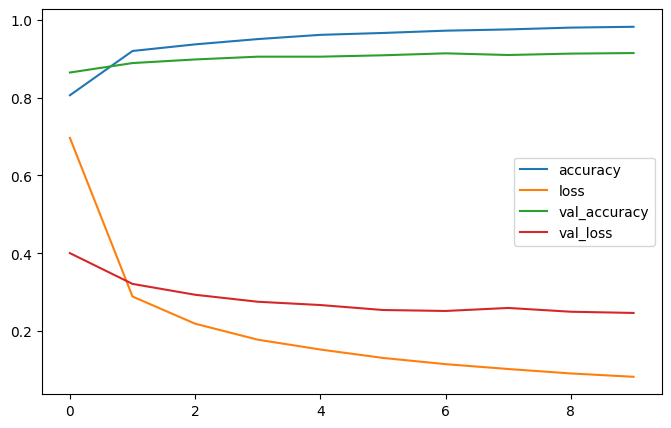

In [ ]:
pd.DataFrame(history_03L2).plot(figsize=(8,5))
plt.show()

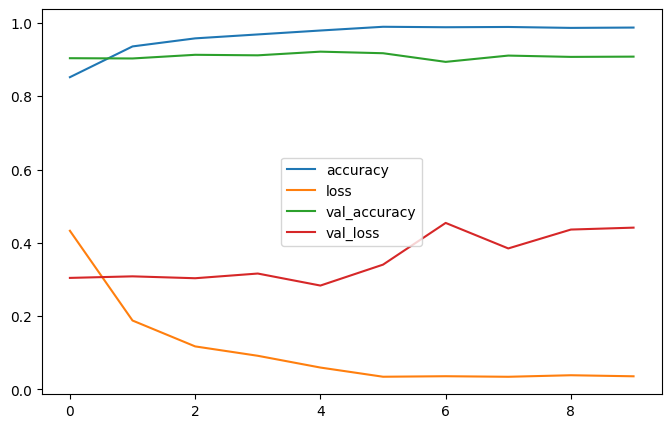

In [ ]:
pd.DataFrame(history1L1).plot(figsize=(8,5))
plt.show()

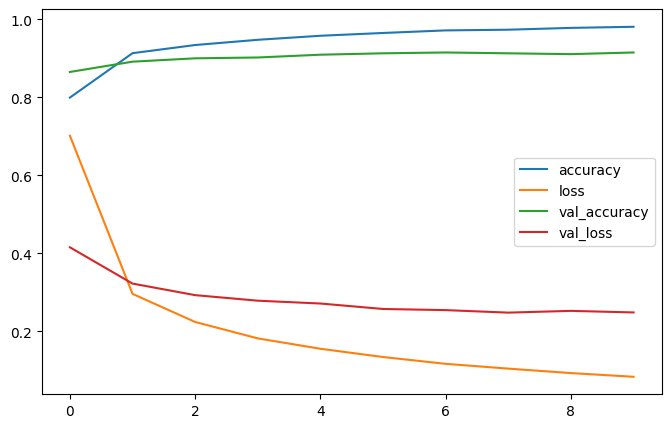

In [ ]:
pd.DataFrame(history4_NoAUG).plot(figsize=(8,5))
plt.show()

### With augmentation

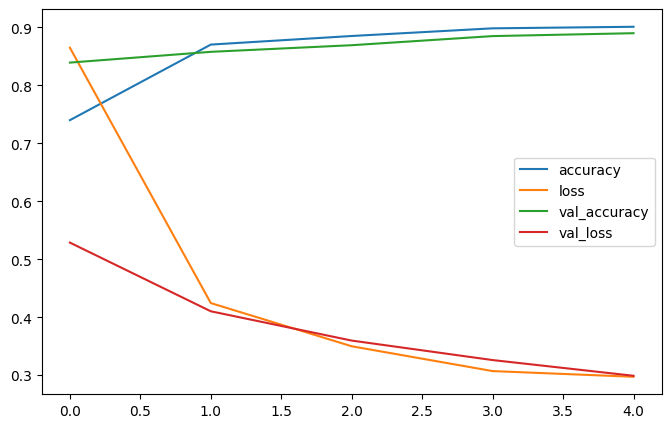

In [ ]:
pd.DataFrame(history_01L2).plot(figsize=(8,5))
plt.show()

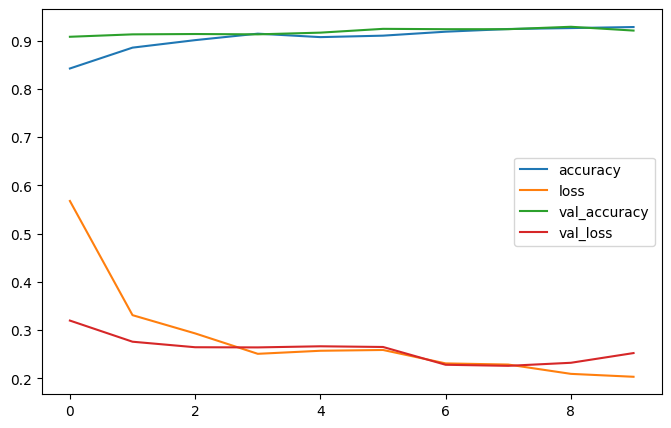

In [ ]:
pd.DataFrame(history1L2).plot(figsize=(8,5))
plt.show()

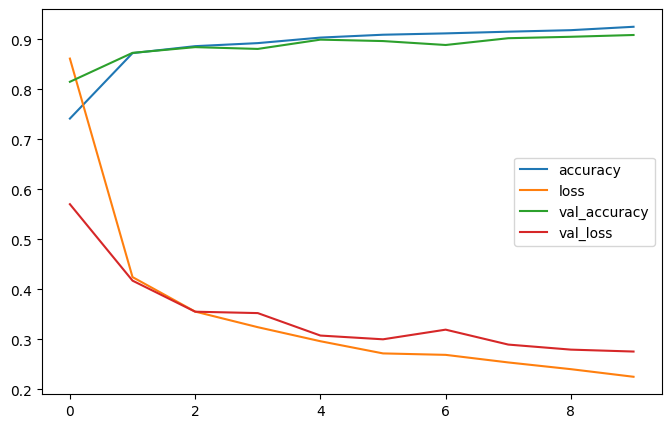

In [ ]:
pd.DataFrame(history_01L3).plot(figsize=(8,5))
plt.show()

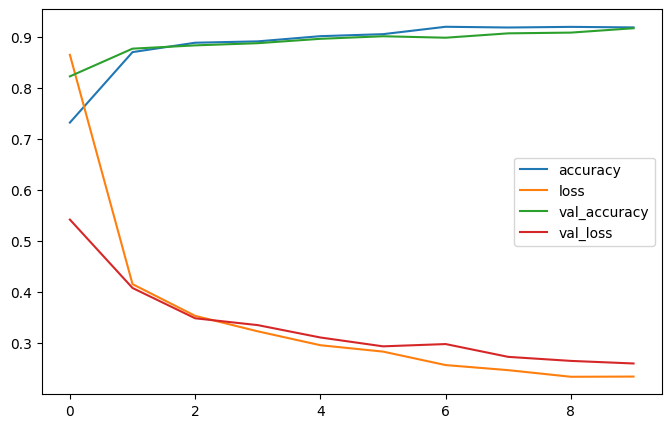

In [ ]:
pd.DataFrame(history4_AUG.history).plot(figsize=(8,5))
plt.show()

## Fine Tuning: Intro


In [ ]:
# Model checkpoint callback
checkpoint_path = "/content/drive/MyDrive/EuroSAT/Models/Limited/checkpoint.weights.h5"
checkpoint_callback= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, save_freq="epoch", verbose=1)

In [ ]:
initial_epochs=10
history_img_generator_aug = model_2.fit(train_datasetA, epochs=initial_epochs, validation_data=test_datasetA, callbacks=[checkpoint_callback, tensorflow_callback('transfer_learning', "limiteddataset_Gen_aug")])

Saving the log files to: transfer_learning/limiteddataset_Gen_aug/20240911-165147
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.9290 - loss: 0.2020
Epoch 1: val_loss improved from inf to 0.24515, saving model to /content/drive/MyDrive/EuroSAT/Models/Limited/checkpoint.weights.h5
175/175 ━━━━━━━━━━━━━━━━━━━━ 71s 388ms/step - accuracy: 0.9290 - loss: 0.2020 - val_accuracy: 0.9236 - val_loss: 0.2452
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.9405 - loss: 0.1762
Epoch 2: val_loss improved from 0.24515 to 0.24216, saving model to /content/drive/MyDrive/EuroSAT/Models/Limited/checkpoint.weights.h5
175/175 ━━━━━━━━━━━━━━━━━━━━ 72s 398ms/step - accuracy: 0.9404 - loss: 0.1763 - val_accuracy: 0.9236 - val_loss: 0.2422
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.9315 - loss: 0.2041
Epoch 3: val_loss did not improve from 0.24216
175/175 ━━━━━━━━━━━━━━━━━━━━ 70s 383ms/step - accuracy: 0.9315 - loss: 0.2041 - val_accuracy: 0.918

In [ ]:
model_2.load_weights(checkpoint_path)
loaded_weights_results1 = model_2.evaluate(test_datasetA)
loaded_weights_results1

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9302 - loss: 0.2373


[0.22912324965000153, 0.9292857050895691]

In [ ]:
checkpoint_path = "/content/drive/MyDrive/EuroSAT/Models/Limited/checkpoint1.weights.h5"
checkpoint_callback= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, save_freq="epoch", verbose=1)

In [ ]:
nitial_epochs=10
history_img_generator_Noaug = model_03L1.fit(train_dataset1, epochs=initial_epochs, validation_data=test_dataset1, callbacks=[checkpoint_callback, tensorflow_callback('transfer_learning', "limiteddataset_Gen_Noaug")])

Saving the log files to: transfer_learning/limiteddataset_Gen_Noaug/20240911-170748
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9625 - loss: 0.1354
Epoch 1: val_loss improved from inf to 0.26525, saving model to /content/drive/MyDrive/EuroSAT/Models/Limited/checkpoint1.weights.h5
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.9625 - loss: 0.1354 - val_accuracy: 0.9086 - val_loss: 0.2652
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9709 - loss: 0.1167
Epoch 2: val_loss improved from 0.26525 to 0.25827, saving model to /content/drive/MyDrive/EuroSAT/Models/Limited/checkpoint1.weights.h5
175/175 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.9709 - loss: 0.1167 - val_accuracy: 0.9121 - val_loss: 0.2583
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9745 - loss: 0.1013
Epoch 3: val_loss did not improve from 0.25827
175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.9745 - loss: 0.1013 - val_accuracy: 0.91

In [ ]:
model_03L1.load_weights(checkpoint_path)
loaded_weights_results1 = model_03L1.evaluate(test_dataset1)
loaded_weights_results1

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9027 - loss: 0.2984


[0.249660924077034, 0.9135714173316956]

In [ ]:
heckpoint_path = "/content/drive/MyDrive/EuroSAT/Models/Limited/checkpoint2.weights.h5"
checkpoint_callback= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, save_freq="epoch", verbose=1)

In [ ]:
nitial_epochs=10
history_img_generator_Noaug = model_03L2.fit(train_dataset1, epochs=initial_epochs, validation_data=test_dataset1, callbacks=[checkpoint_callback, tensorflow_callback('transfer_learning', "limiteddataset_Gen_Noaug")])

Saving the log files to: transfer_learning/limiteddataset_Gen_Noaug/20240911-174339
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9864 - loss: 0.0729
Epoch 1: val_loss improved from inf to 0.25633, saving model to /content/drive/MyDrive/EuroSAT/Models/Limited/checkpoint1.weights.h5
175/175 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.9864 - loss: 0.0729 - val_accuracy: 0.9121 - val_loss: 0.2563
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9874 - loss: 0.0668
Epoch 2: val_loss improved from 0.25633 to 0.24489, saving model to /content/drive/MyDrive/EuroSAT/Models/Limited/checkpoint1.weights.h5
175/175 ━━━━━━━━━━━━━━━━━━━━ 24s 132ms/step - accuracy: 0.9874 - loss: 0.0668 - val_accuracy: 0.9171 - val_loss: 0.2449
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9904 - loss: 0.0560
Epoch 3: val_loss did not improve from 0.24489
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.9904 - loss: 0.0560 - val_accuracy: 0.9

In [ ]:
model_03L2.load_weights(checkpoint_path)
loaded_weights_results2 = model_03L1.evaluate(test_dataset1)
loaded_weights_results2

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.9027 - loss: 0.2984


[0.249660924077034, 0.9135714173316956]

In [ ]:
checkpoint_path = "/content/drive/MyDrive/EuroSAT/Models/Limited/checkpoint3.weights.h5"
checkpoint_callback= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, save_freq="epoch", verbose=1)

In [ ]:
nitial_epochs=10
history_img_generator_aug2 = model_4.fit(train_datasetA, epochs=initial_epochs, validation_data=test_datasetA, callbacks=[checkpoint_callback, tensorflow_callback('transfer_learning', "limiteddataset_Gen_Noaug")])

Saving the log files to: transfer_learning/limiteddataset_Gen_Noaug/20240911-195204
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9285 - loss: 0.2190
Epoch 1: val_loss improved from inf to 0.26212, saving model to /content/drive/MyDrive/EuroSAT/Models/Limited/checkpoint3.weights.h5
175/175 ━━━━━━━━━━━━━━━━━━━━ 70s 381ms/step - accuracy: 0.9284 - loss: 0.2190 - val_accuracy: 0.9121 - val_loss: 0.2621
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9290 - loss: 0.2105
Epoch 2: val_loss did not improve from 0.26212
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 377ms/step - accuracy: 0.9290 - loss: 0.2106 - val_accuracy: 0.9121 - val_loss: 0.2700
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.9266 - loss: 0.2105
Epoch 3: val_loss improved from 0.26212 to 0.26196, saving model to /content/drive/MyDrive/EuroSAT/Models/Limited/checkpoint3.weights.h5
175/175 ━━━━━━━━━━━━━━━━━━━━ 72s 397ms/step - accuracy: 0.9266 - loss: 0.2105 - val_accuracy: 0

In [ ]:
model_4.load_weights(checkpoint_path)
loaded_weights_results2 = model_4.evaluate(test_datasetA)
loaded_weights_results2

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9183 - loss: 0.2556


[0.24071234464645386, 0.9178571701049805]

In [ ]:
checkpoint_path = "/content/drive/MyDrive/EuroSAT/Models/Limited/checkpoint4.weights.h5"
checkpoint_callback= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, save_freq="epoch", verbose=1)

In [ ]:
initial_epochs=10
history_img_generator_Noaug2 = model_4.fit(train_dataset1, epochs=initial_epochs, validation_data=test_dataset1, callbacks=[checkpoint_callback, tensorflow_callback('transfer_learning', "limiteddataset_Gen_Noaug1")])

Saving the log files to: transfer_learning/limiteddataset_Gen_Noaug1/20240911-183133
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9646 - loss: 0.1116
Epoch 1: val_loss improved from inf to 0.20661, saving model to /content/drive/MyDrive/EuroSAT/Models/Limited/checkpoint4.weights.h5
175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.9646 - loss: 0.1115 - val_accuracy: 0.9257 - val_loss: 0.2066
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9812 - loss: 0.0840
Epoch 2: val_loss improved from 0.20661 to 0.20520, saving model to /content/drive/MyDrive/EuroSAT/Models/Limited/checkpoint4.weights.h5
175/175 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.9811 - loss: 0.0840 - val_accuracy: 0.9271 - val_loss: 0.2052
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9821 - loss: 0.0739
Epoch 3: val_loss improved from 0.20520 to 0.20310, saving model to /content/drive/MyDrive/EuroSAT/Models/Limited/checkpoint4.weights.h5
175/175

In [ ]:
model_4.load_weights(checkpoint_path)
loaded_weights_results3 = model_4.evaluate(test_dataset1)
loaded_weights_results3

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9317 - loss: 0.2088


[0.20131446421146393, 0.927142858505249]

### Fine Tuning pt2

Model_4 gives the best results with data augmentation, so I will try to tune the parammeters on this model.
Path to weights: checkpoint_path = "/content/drive/MyDrive/EuroSAT/Models/Limited/checkpoint3.weights.h5"

In [ ]:
model_4.layers

[<InputLayer name=input_layer, built=True>,
 <Functional name=resnet50v2, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling_layer, built=True>,
 <Dense name=output_layer, built=True>]

In [ ]:
for layer_number, layer in enumerate(model_4.layers):
  print(f"Layer number: {layer_number} | Layer name: {layer.name} | Layer type: {layer} | Trainable? {layer.trainable}")


Layer number: 0 | Layer name: input_layer | Layer type: <InputLayer name=input_layer, built=True> | Trainable? True
Layer number: 1 | Layer name: resnet50v2 | Layer type: <Functional name=resnet50v2, built=True> | Trainable? False
Layer number: 2 | Layer name: global_average_pooling_layer | Layer type: <GlobalAveragePooling2D name=global_average_pooling_layer, built=True> | Trainable? True
Layer number: 3 | Layer name: output_layer | Layer type: <Dense name=output_layer, built=True> | Trainable? True


In [ ]:
model_4.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,626,272 (90.13 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 40,982 (160.09 KB)

In [ ]:
model_4_base_model=model_4.layers[1]
model_4_base_model.name

'resnet50v2'

In [ ]:
for layer_num, layer in enumerate(model_4_base_model.layers):
  print(layer_num, layer.name, layer.trainable)

0 input_layer_9 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv

In [ ]:
model_4_base_model.trainable=True

for layer in model_4_base_model.layers[:-5]:
  layer.trainable=False

model_4.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

In [ ]:
for layer_num, layer in enumerate(model_4_base_model.layers):
  print(layer_num, layer.name, layer.trainable)

0 input_layer_9 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv

In [ ]:
print(len(model_4.trainable_variables))

6


In [ ]:
history4_AUG

In [ ]:
fine_tune_epochs = initial_epochs + 5
history_fine_tune_AUG= model_4.fit(train_datasetA, epochs=fine_tune_epochs, initial_epoch=history4_AUG.epoch[-1], validation_data=test_datasetA, callbacks=[tensorflow_callback('transfer_learning', "limiteddataset_Gen_augFineTune")])

Saving the log files to: transfer_learning/limiteddataset_Gen_augFineTune/20240911-200647
Epoch 10/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 81s 403ms/step - accuracy: 0.8943 - loss: 0.3169 - val_accuracy: 0.9157 - val_loss: 0.2741
Epoch 11/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 377ms/step - accuracy: 0.9307 - loss: 0.2022 - val_accuracy: 0.9050 - val_loss: 0.3112
Epoch 12/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 380ms/step - accuracy: 0.9328 - loss: 0.2005 - val_accuracy: 0.9250 - val_loss: 0.2599
Epoch 13/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 377ms/step - accuracy: 0.9341 - loss: 0.1839 - val_accuracy: 0.9271 - val_loss: 0.2554
Epoch 14/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 377ms/step - accuracy: 0.9360 - loss: 0.1843 - val_accuracy: 0.9264 - val_loss: 0.2412
Epoch 15/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 378ms/step - accuracy: 0.9455 - loss: 0.1543 - val_accuracy: 0.9271 - val_loss: 0.2589


In [ ]:
results_fine_tune = model_4.evaluate(test_datasetA)
results_fine_tune

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9333 - loss: 0.2441


[0.2589108347892761, 0.927142858505249]

In [ ]:
def compare_history(original_history, new_history, initial_epochs=10):
  # Original history
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]
  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history with new history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]
  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Create separate plots for accuracy and loss
  plt.figure(figsize=(10,10))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Validation Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Fine Tuning Start")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  plt.subplot(2,1,2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Validation Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Fine Tuning Start")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")
  plt.xlabel("Epochs")
  plt.show()


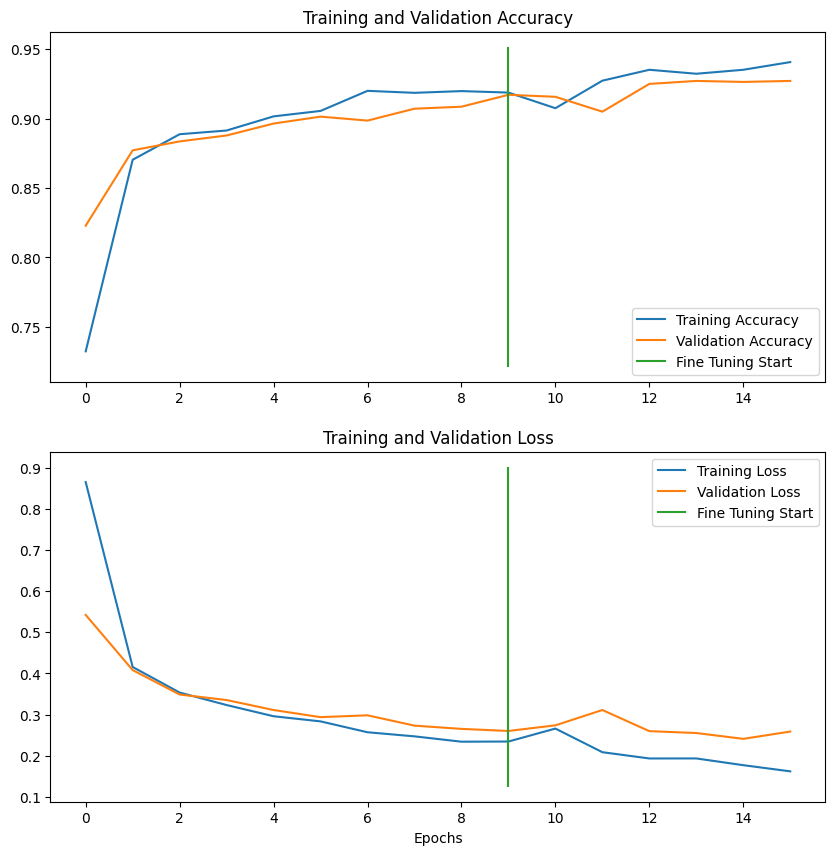

In [ ]:
compare_history(original_history=history4_AUG,
                new_history=history_fine_tune_AUG, initial_epochs=10)

## image_dataset_from_directory

### Data preparation

In [87]:
train_data_limited1= tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR,
                                                                         shuffle=True,
                                                                         batch_size=batch_size,
                                                                         image_size=IMG_SIZE,
                                                                         label_mode='categorical'
                                                                         )
test_data_limited1 = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR,
                                                                         shuffle=False,
                                                                         image_size=IMG_SIZE,
                                                                         batch_size=batch_size,
                                                                         label_mode='categorical')

Found 5600 files belonging to 10 classes.
Found 1400 files belonging to 10 classes.


In [18]:
train_data_limited1

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [19]:
train_data_limited1.class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [20]:
for images, labels in train_data_limited1.take(1):
  print(images, labels)

tf.Tensor(
[[[[ 43.        67.       101.      ]
   [ 43.        67.       101.      ]
   [ 43.214287  67.21429  101.21429 ]
   ...
   [ 53.428566  76.428566 108.428566]
   [ 53.        76.       108.      ]
   [ 53.        76.       108.      ]]

  [[ 43.        67.       101.      ]
   [ 43.        67.       101.      ]
   [ 43.214287  67.21429  101.21429 ]
   ...
   [ 53.428566  76.428566 108.428566]
   [ 53.        76.       108.      ]
   [ 53.        76.       108.      ]]

  [[ 42.785713  67.21429  101.      ]
   [ 42.785713  67.21429  101.      ]
   [ 42.954082  67.38265  101.168365]
   ...
   [ 53.38265   76.382645 108.382645]
   [ 53.        76.       108.      ]
   [ 53.        76.       108.      ]]

  ...

  [[ 55.50002   82.500015 111.500015]
   [ 55.50002   82.500015 111.500015]
   [ 55.545937  82.4541   111.500015]
   ...
   [ 51.71938   74.719376 105.719376]
   [ 51.857132  74.85713  105.85713 ]
   [ 51.857132  74.85713  105.85713 ]]

  [[ 57.        84.       113.    

In [88]:
AUTOTUNE = tf.data.AUTOTUNE
train_data_limited1 = train_data_limited1.cache().prefetch(buffer_size=AUTOTUNE)
test_data_limited1 = test_data_limited1.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
print(len(train_data_limited1))
print(len(test_data_limited1))

175
44


In [23]:
print(int(0.5*len(train_data_limited1)))

87


In [89]:
# train_dataset = train_data_limited1.repeat(10)
# test_dataset = test_data_limited1.repeat(10)
# steps_per_epoch = len(train_data_limited1) // batch_size
# validation_steps = len(test_data_limited1) // batch_size
train_dataset = train_data_limited1.repeat(10)
test_dataset = test_data_limited1
steps_per_epoch = int(0.5*len(train_data_limited1))
# validation_steps =int(0.25* len(test_data_limited1))

#### Data Augmentation

In [26]:
data_augmentation = keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomContrast(0.2),
    layers.RandomFlip("vertical")
], name="data_augmentation")

In [28]:
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable=False
# Building the model
input_shape= (224,224,3)
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Normalising the data
x = data_augmentation(inputs)

x = base_model(x, training=False)
print(f"Shape after base_model: {x.shape}")

# Average pool the outputs to reduce the computations
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling: {x.shape}")
# x = tf.keras.layers.Dense(units=1025, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.2)(x) # to prevent overfitting
# x = tf.keras.layers.Dense(units=1025, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.2)(x) # to prevent overfitting
# Add the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_1L = tf.keras.Model(inputs, outputs)

#Compiling the model
model_1L.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_1L = model_1L.fit(train_dataset,epochs=5,
                          validation_data=test_dataset,
                          # steps_per_epoch=steps_per_epoch,
                          # validation_steps=validation_steps,
                          callbacks=[tensorflow_callback('transfer_learning', "limiteddataset_resnet50v2_1L")])

Shape after base_model: (None, None, None, 2048)
Shape after Global Average Pooling: (None, 2048)
Saving the log files to: transfer_learning/limiteddataset_resnet50v2_1L/20240912-235128
Epoch 1/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.6000 - loss: 1.3147 - val_accuracy: 0.8536 - val_loss: 0.4875
Epoch 2/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 66s 378ms/step - accuracy: 0.8627 - loss: 0.4855 - val_accuracy: 0.8750 - val_loss: 0.3894
Epoch 3/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 48s 274ms/step - accuracy: 0.8860 - loss: 0.3715 - val_accuracy: 0.8850 - val_loss: 0.3419
Epoch 4/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 43s 244ms/step - accuracy: 0.8859 - loss: 0.3555 - val_accuracy: 0.8971 - val_loss: 0.3192
Epoch 5/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 40s 229ms/step - accuracy: 0.8978 - loss: 0.3099 - val_accuracy: 0.9064 - val_loss: 0.2968


In [40]:
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable=False
# Building the model
input_shape= (224,224,3)
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Normalising the data
x = data_augmentation(inputs)

x = base_model(x, training=False)
print(f"Shape after base_model: {x.shape}")

# Average pool the outputs to reduce the computations
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling: {x.shape}")

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_1AGL = tf.keras.Model(inputs, outputs)

#Compiling the model
model_1AGL.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_1AGL = model_1AGL.fit(train_dataset,epochs=10,
                          validation_data=test_dataset,
                          # steps_per_epoch=steps_per_epoch,
                          # validation_steps=validation_steps,
                          callbacks=[tensorflow_callback('transfer_learning', "limiteddataset_resnet50v2_AGL")])

Shape after base_model: (None, None, None, 2048)
Shape after Global Average Pooling: (None, 2048)
Saving the log files to: transfer_learning/limiteddataset_resnet50v2_AGL/20240913-115744
Epoch 1/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 278s 156ms/step - accuracy: 0.8241 - loss: 0.5878 - val_accuracy: 0.9150 - val_loss: 0.2582
Epoch 2/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 255s 146ms/step - accuracy: 0.9234 - loss: 0.2308 - val_accuracy: 0.9186 - val_loss: 0.2506
Epoch 3/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 247s 141ms/step - accuracy: 0.9308 - loss: 0.2025 - val_accuracy: 0.9207 - val_loss: 0.2359
Epoch 4/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 239s 137ms/step - accuracy: 0.9391 - loss: 0.1834 - val_accuracy: 0.9257 - val_loss: 0.2202
Epoch 5/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 232s 133ms/step - accuracy: 0.9406 - loss: 0.1749 - val_accuracy: 0.9257 - val_loss: 0.2262
Epoch 6/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 227s 130ms/step - accuracy: 0.9426 - loss: 0.1645 - val_accuracy: 0.9243 - val_loss: 0.2295
Epoch 7/1

In [ ]:
model_1L.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, None, None, 2048)    │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,626,272 (90.13 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 40,982 (160.09 KB)

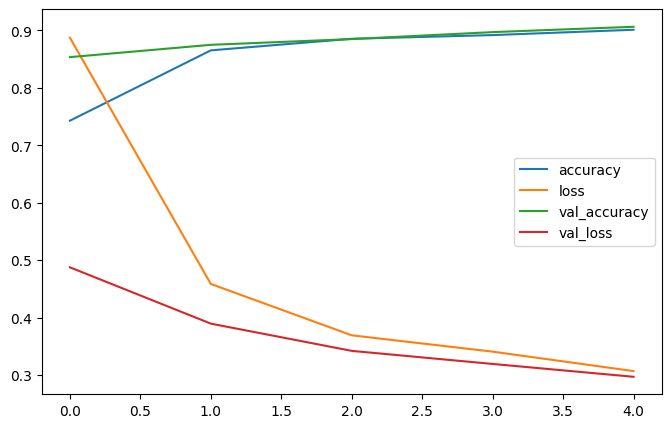

In [29]:
pd.DataFrame(history_1L.history).plot(figsize=(8,5))
plt.show()

In [30]:
base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')
base_model.trainable=False
# Building the model
input_shape= (224,224,3)
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Normalising the data
x = data_augmentation(inputs)

x = base_model(x, training=False)
print(f"Shape after base_model: {x.shape}")

# Average pool the outputs to reduce the computations
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling: {x.shape}")
# x = tf.keras.layers.Dense(units=1025, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.2)(x) # to prevent overfitting
# x = tf.keras.layers.Dense(units=1025, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.2)(x) # to prevent overfitting
# Add the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_AGL = tf.keras.Model(inputs, outputs)

#Compiling the model
model_AGL.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_AGL = model_AGL.fit(train_dataset,epochs=5,
                          validation_data=test_dataset,
                          steps_per_epoch=steps_per_epoch,
                          # validation_steps=validation_steps,
                          callbacks=[tensorflow_callback('transfer_learning', "limiteddataset_resnet50v2_AGL")])

Shape after base_model: (None, None, None, 2048)
Shape after Global Average Pooling: (None, 2048)
Saving the log files to: transfer_learning/limiteddataset_resnet50v2_AGL/20240913-105707
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 36s 348ms/step - accuracy: 0.4770 - loss: 1.6343 - val_accuracy: 0.8329 - val_loss: 0.6365
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 28s 325ms/step - accuracy: 0.8271 - loss: 0.6202 - val_accuracy: 0.8614 - val_loss: 0.4833
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 305ms/step - accuracy: 0.8652 - loss: 0.4885 - val_accuracy: 0.8700 - val_loss: 0.4074
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 259ms/step - accuracy: 0.8690 - loss: 0.4530 - val_accuracy: 0.8836 - val_loss: 0.3677
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 283ms/step - accuracy: 0.8781 - loss: 0.4097 - val_accuracy: 0.8900 - val_loss: 0.3520


In [32]:
base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')
base_model.trainable=False
# Building the model
input_shape= (224,224,3)
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Normalising the data
x = data_augmentation(inputs)

x = base_model(x, training=False)
print(f"Shape after base_model: {x.shape}")

# Average pool the outputs to reduce the computations
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling: {x.shape}")
# x = tf.keras.layers.Dense(units=1025, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.2)(x) # to prevent overfitting
# x = tf.keras.layers.Dense(units=1025, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.2)(x) # to prevent overfitting
# Add the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_AGL1 = tf.keras.Model(inputs, outputs)

#Compiling the model
model_AGL1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_AGL1 = model_AGL1.fit(train_dataset,epochs=10,
                          validation_data=test_dataset,
                          steps_per_epoch=steps_per_epoch,
                          # validation_steps=validation_steps,
                          callbacks=[tensorflow_callback('transfer_learning', "limiteddataset_resnet50v2_AGL1")])

Shape after base_model: (None, None, None, 2048)
Shape after Global Average Pooling: (None, 2048)
Saving the log files to: transfer_learning/limiteddataset_resnet50v2_AGL1/20240913-110339
Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 246ms/step - accuracy: 0.4956 - loss: 1.5698 - val_accuracy: 0.8250 - val_loss: 0.6546
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - accuracy: 0.8185 - loss: 0.6389 - val_accuracy: 0.8643 - val_loss: 0.4791
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 21s 245ms/step - accuracy: 0.8466 - loss: 0.5134 - val_accuracy: 0.8771 - val_loss: 0.4159
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 213ms/step - accuracy: 0.8712 - loss: 0.4305 - val_accuracy: 0.8779 - val_loss: 0.3895
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 225ms/step - accuracy: 0.8848 - loss: 0.3928 - val_accuracy: 0.8886 - val_loss: 0.3555
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 22s 256ms/step - accuracy: 0.8759 - loss: 0.3926 - val_accuracy: 0.8893 - val_loss: 0.3425
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable=False
# Building the model
input_shape= (224,224,3)
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Normalising the data
x = data_augmentation(inputs)

x = base_model(x, training=False)
print(f"Shape after base_model: {x.shape}")

# Average pool the outputs to reduce the computations
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling: {x.shape}")
x = tf.keras.layers.Dense(units=1025, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x) # to prevent overfitting
x = tf.keras.layers.Dense(units=1025, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x) # to prevent overfitting
# Add the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_4L = tf.keras.Model(inputs, outputs)

#Compiling the model
model_4L.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_4L = model_4L.fit(train_dataset,epochs=5,
                          validation_data=test_dataset,
                          # steps_per_epoch=steps_per_epoch,
                          # validation_steps=validation_steps,
                          callbacks=[tensorflow_callback('transfer_learning', "limiteddataset_resnet50v2_4L")]).history

Shape after base_model: (None, None, None, 2048)
Shape after Global Average Pooling: (None, 2048)
Saving the log files to: transfer_learning/limiteddataset_resnet50v2_4L/20240911-171645
Epoch 1/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - accuracy: 0.6945 - loss: 0.9113 - val_accuracy: 0.8764 - val_loss: 0.3643
Epoch 2/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 33s 185ms/step - accuracy: 0.8605 - loss: 0.4074 - val_accuracy: 0.8879 - val_loss: 0.3323
Epoch 3/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 31s 178ms/step - accuracy: 0.8866 - loss: 0.3341 - val_accuracy: 0.8964 - val_loss: 0.3373
Epoch 4/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 31s 178ms/step - accuracy: 0.8917 - loss: 0.3321 - val_accuracy: 0.9071 - val_loss: 0.3216
Epoch 5/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 32s 183ms/step - accuracy: 0.8974 - loss: 0.3030 - val_accuracy: 0.8907 - val_loss: 0.3614


#### No data augmentation

In [34]:
base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')
base_model.trainable=False
# Building the model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# Normalising the data
x = tf.keras.layers.Rescaling(1./255)(inputs)

x = base_model(x)
print(f"Shape after base_model: {x.shape}")

# Average pool the outputs to reduce the computations
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling: {x.shape}")

# Add the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_NOAGL = tf.keras.Model(inputs, outputs)

#Compiling the model
model_NOAGL.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_NOAGL = model_NOAGL.fit(train_dataset,epochs=10,validation_data=test_dataset, steps_per_epoch=steps_per_epoch,  callbacks=[tensorflow_callback('transfer_learning', "limiteddataset_resnet50_NOAGL")])

Shape after base_model: (None, 7, 7, 2048)
Shape after Global Average Pooling: (None, 2048)
Saving the log files to: transfer_learning/limiteddataset_resnet50_NOAGL/20240913-111701
Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 179ms/step - accuracy: 0.5196 - loss: 1.5643 - val_accuracy: 0.8450 - val_loss: 0.5818
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.8689 - loss: 0.4941 - val_accuracy: 0.8743 - val_loss: 0.4279
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.9151 - loss: 0.3380 - val_accuracy: 0.8843 - val_loss: 0.3748
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.9140 - loss: 0.2988 - val_accuracy: 0.8950 - val_loss: 0.3386
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.9355 - loss: 0.2451 - val_accuracy: 0.8971 - val_loss: 0.3227
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.9298 - loss: 0.2406 - val_accuracy: 0.8943 - val_loss: 0.3052
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - ac

In [35]:
model_NOAGL.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,626,272 (90.13 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 40,982 (160.09 KB)

In [38]:
base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')
base_model.trainable=False
# Building the model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# Normalising the data
x = tf.keras.layers.Rescaling(1./255)(inputs)

x = base_model(x)
print(f"Shape after base_model: {x.shape}")

# Average pool the outputs to reduce the computations
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling: {x.shape}")
x = tf.keras.layers.Dense(units=128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x) # to prevent overfitting
x = tf.keras.layers.Dense(units=64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x) # to prevent overfitting

# Add the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_NOAGL1 = tf.keras.Model(inputs, outputs)

#Compiling the model
model_NOAGL1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_NOAGL1 = model_NOAGL1.fit(train_dataset,epochs=10,validation_data=test_dataset, steps_per_epoch=steps_per_epoch,  callbacks=[tensorflow_callback('transfer_learning', "limiteddataset_resnet50_NOAGL1")])

Shape after base_model: (None, 7, 7, 2048)
Shape after Global Average Pooling: (None, 2048)
Saving the log files to: transfer_learning/limiteddataset_resnet50_NOAGL1/20240913-112349
Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 22s 143ms/step - accuracy: 0.5250 - loss: 1.4664 - val_accuracy: 0.8600 - val_loss: 0.4331
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.8361 - loss: 0.5100 - val_accuracy: 0.8907 - val_loss: 0.3456
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.8878 - loss: 0.3539 - val_accuracy: 0.8971 - val_loss: 0.2954
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.8974 - loss: 0.3073 - val_accuracy: 0.9000 - val_loss: 0.2998
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.9235 - loss: 0.2422 - val_accuracy: 0.9007 - val_loss: 0.2982
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.9122 - loss: 0.2637 - val_accuracy: 0.9093 - val_loss: 0.2758
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step -

In [45]:
base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')
base_model.trainable=False
# Building the model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# Normalising the data
x = tf.keras.layers.Rescaling(1./255)(inputs)

x = base_model(x)
print(f"Shape after base_model: {x.shape}")

# Average pool the outputs to reduce the computations
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling: {x.shape}")
x = tf.keras.layers.Dense(units=128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x) # to prevent overfitting
x = tf.keras.layers.Dense(units=64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x) # to prevent overfitting

# Add the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_NOAGL2 = tf.keras.Model(inputs, outputs)

#Compiling the model
model_NOAGL2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_NOAGL2 = model_NOAGL2.fit(train_dataset,epochs=10,validation_data=test_dataset, callbacks=[tensorflow_callback('transfer_learning', "limiteddataset_resnet50_NOAGL2")])

Shape after base_model: (None, 7, 7, 2048)
Shape after Global Average Pooling: (None, 2048)
Saving the log files to: transfer_learning/limiteddataset_resnet50_NOAGL2/20240913-125402
Epoch 1/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 133s 71ms/step - accuracy: 0.8616 - loss: 0.4309 - val_accuracy: 0.9171 - val_loss: 0.3612
Epoch 2/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 117s 67ms/step - accuracy: 0.9847 - loss: 0.0451 - val_accuracy: 0.9136 - val_loss: 0.4629
Epoch 3/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 117s 67ms/step - accuracy: 0.9908 - loss: 0.0262 - val_accuracy: 0.9171 - val_loss: 0.4856
Epoch 4/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 117s 67ms/step - accuracy: 0.9945 - loss: 0.0182 - val_accuracy: 0.9114 - val_loss: 0.5788
Epoch 5/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 117s 67ms/step - accuracy: 0.9941 - loss: 0.0199 - val_accuracy: 0.9107 - val_loss: 0.7835
Epoch 6/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 117s 67ms/step - accuracy: 0.9936 - loss: 0.0187 - val_accuracy: 0.9200 - val_loss: 0.6832
Epoch 7/10
1750/1750

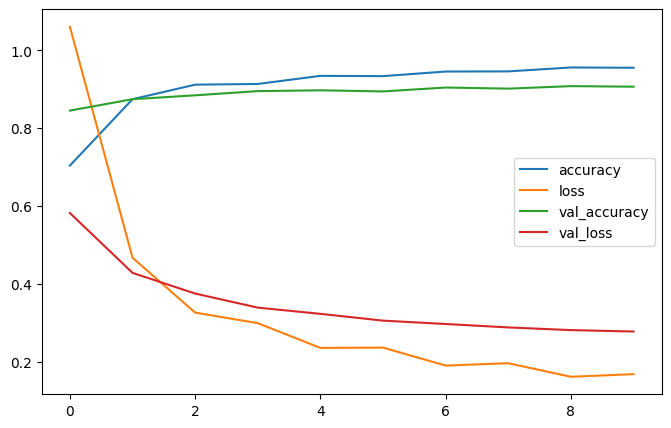

In [36]:
pd.DataFrame(history_NOAGL.history).plot(figsize=(8,5))
plt.show()

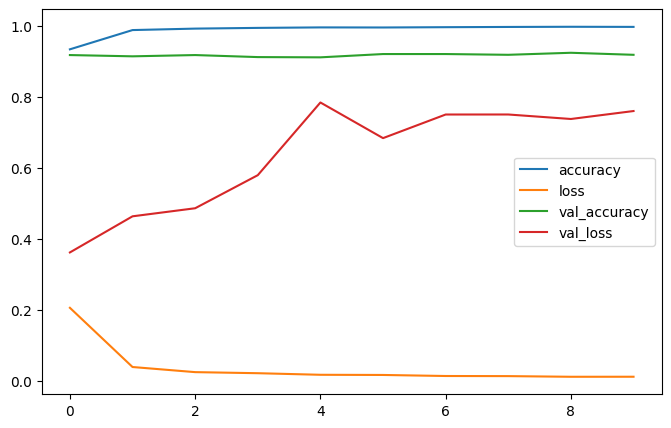

In [46]:
pd.DataFrame(history_NOAGL2.history).plot(figsize=(8,5))
plt.show()

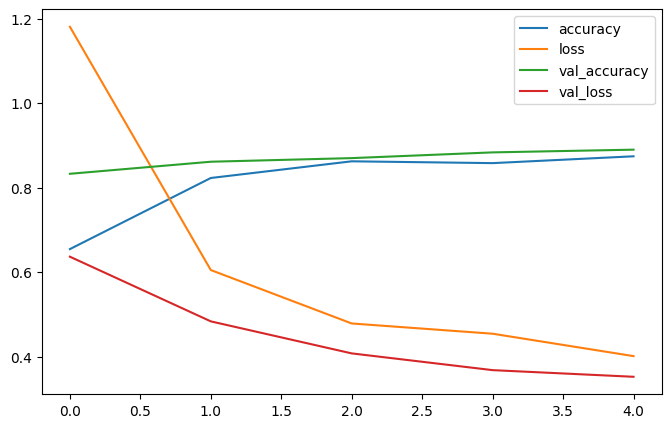

In [31]:
pd.DataFrame(history_AGL.history).plot(figsize=(8,5))
plt.show()

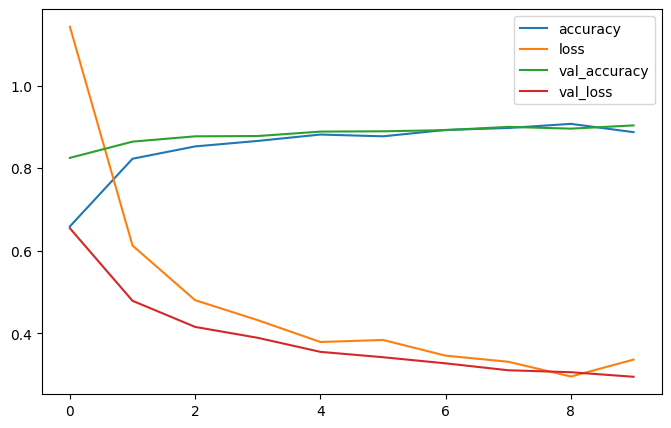

In [33]:
pd.DataFrame(history_AGL1.history).plot(figsize=(8,5))
plt.show()

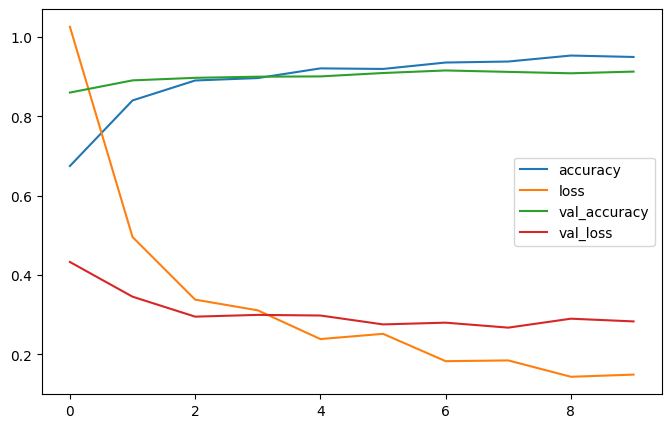

In [39]:
pd.DataFrame(history_NOAGL1.history).plot(figsize=(8,5))
plt.show()

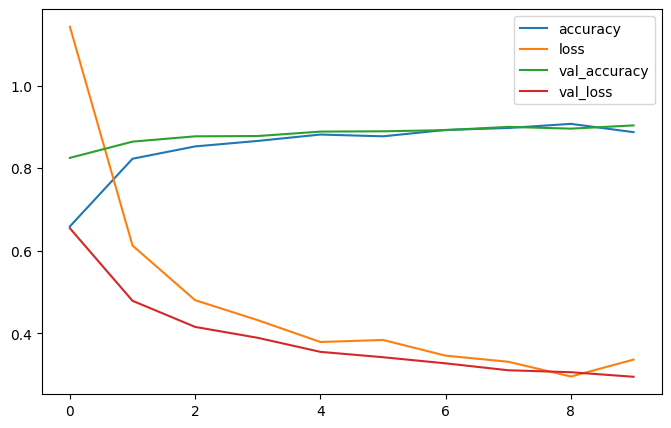

In [42]:
pd.DataFrame(history_AGL1.history).plot(figsize=(8,5))
plt.show()

In [47]:
base_model.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, None, None, 64) │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, None, None, 64) │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, None, None, 64) │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, None, None, 64) │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None, 64) │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None, 64) │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None, 64) │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, None, None, 64) │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 64) │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, None, None, 64) │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, None, None, 64) │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
resultsL_ID_AG = model_1L.evaluate(test_dataset)
resultsL_ID_AG


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.8931 - loss: 0.3186


[0.27275633811950684, 0.9028571248054504]

In [43]:
resultsL_ID_AGL1 = model_AGL1.evaluate(test_dataset)
resultsL_ID_AGL1

44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.8973 - loss: 0.3281


[0.29521840810775757, 0.9035714268684387]

In [44]:
resultsL_ID_AGL = model_AGL.evaluate(test_dataset)
resultsL_ID_AGL

44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.8725 - loss: 0.4075


[0.3520260155200958, 0.8899999856948853]

In [37]:
resultsL_ID_NOAG = model_NOAGL.evaluate(test_dataset)
resultsL_ID_NOAG

44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.8983 - loss: 0.3066


[0.27724534273147583, 0.9064285755157471]

In [ ]:
def create_new_model(input_shape: tuple[int,int,int] = (224,224,3), output_shape: int =10, learning_rate: float=0.001, training: bool=False) -> tf.keras.Model:

  #Create base model:
  base_model = tf.keras.applications.ResNet50V2(include_top=False)
  base_model.trainable=training
  # Model inputs and outputs with data augmentation
  inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
  x = tf.keras.layers.Rescaling(1./255)(inputs)
  #x = data_augmentation(inputs)
  #x = base_model(x, training=False)
  x = base_model(x)
  x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
  # x = tf.keras.layers.Dense(units=1025, activation="relu")(x)
  # x = tf.keras.layers.Dropout(0.2)(x) # to prevent overfitting

  outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)
  model = tf.keras.Model(inputs, outputs)

  #Compile the model:
  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])

  return model

In [ ]:
model_5 = create_new_model(training=False)

In [55]:
def create_new_model(input_shape: tuple[int,int,int] = (224,224,3), output_shape: int =10, learning_rate: float=0.001, training: bool=False) -> tf.keras.Model:

  #Create base model:
  base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')
  base_model.trainable=training
  # Model inputs and outputs with data augmentation
  inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
  # x = tf.keras.layers.Rescaling(1./255)(inputs)
  x = data_augmentation(inputs)
  x = base_model(x, training=False)
  # x = base_model(x)
  x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
  # x = tf.keras.layers.Dense(units=1025, activation="relu")(x)
  # x = tf.keras.layers.Dropout(0.2)(x) # to prevent overfitting

  outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)
  model = tf.keras.Model(inputs, outputs)

  #Compile the model:
  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])

  return model

In [56]:
model_6 = create_new_model(training=False)

In [57]:
history6AGSteps = model_6.fit(train_dataset,epochs=10,
                          validation_data=test_dataset,
                          steps_per_epoch=steps_per_epoch,
                          # validation_steps=validation_steps,
                          callbacks=[tensorflow_callback('transfer_learning', "limiteddataset_resnet50v2_6AGL1")])

Saving the log files to: transfer_learning/limiteddataset_resnet50v2_6AGL1/20240913-134057
Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 22s 190ms/step - accuracy: 0.4993 - loss: 1.5810 - val_accuracy: 0.8279 - val_loss: 0.6421
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 176ms/step - accuracy: 0.8216 - loss: 0.6527 - val_accuracy: 0.8593 - val_loss: 0.4746
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 172ms/step - accuracy: 0.8680 - loss: 0.4823 - val_accuracy: 0.8771 - val_loss: 0.4142
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 168ms/step - accuracy: 0.8608 - loss: 0.4522 - val_accuracy: 0.8900 - val_loss: 0.3811
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - accuracy: 0.8892 - loss: 0.3794 - val_accuracy: 0.8879 - val_loss: 0.3698
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - accuracy: 0.8732 - loss: 0.3972 - val_accuracy: 0.8914 - val_loss: 0.3440
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step - accuracy: 0.8863 - loss: 0.3537 - val_accuracy: 0.8936 - val_loss: 0.3437
Epoch 

In [ ]:
history5_NoAUG = model_5.fit(train_dataset, epochs=10, validation_data=test_dataset, callbacks=[tensorflow_callback('transfer_learning', "limiteddataset_resnet50_5NoAUG")]).history

Saving the log files to: transfer_learning/limiteddataset_resnet50_5NoAUG/20240911-185604
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - accuracy: 0.6278 - loss: 1.2087 - val_accuracy: 0.8600 - val_loss: 0.4428
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.9079 - loss: 0.3362 - val_accuracy: 0.8836 - val_loss: 0.3493
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.9278 - loss: 0.2484 - val_accuracy: 0.8907 - val_loss: 0.3133
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.9426 - loss: 0.2021 - val_accuracy: 0.8986 - val_loss: 0.2942
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.9534 - loss: 0.1712 - val_accuracy: 0.9021 - val_loss: 0.2828
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.9639 - loss: 0.1484 - val_accuracy: 0.9071 - val_loss: 0.2755
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.9694 - loss: 0.1306 - val_accuracy: 0.9064 - val_loss: 0.2709


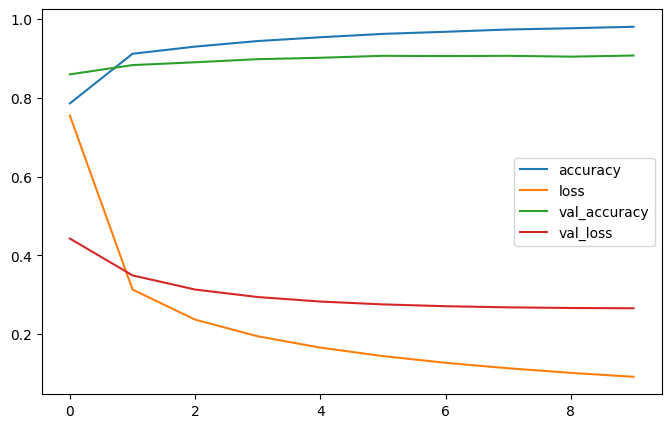

In [ ]:
pd.DataFrame(history5_NoAUG).plot(figsize=(8,5))
plt.show()

In [ ]:
resultsL_ID_NOAG2 = model_5.evaluate(test_dataset)
resultsL_ID_NOAG2

44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9071 - loss: 0.2912


[0.2657088339328766, 0.9078571200370789]

### Fine Tuning

In [58]:
resultsL_ID_AG2L2 = model_6.evaluate(test_dataset)
resultsL_ID_AG2L2

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.8961 - loss: 0.3095


[0.2939290404319763, 0.904285728931427]

In [59]:
checkpoint_path = "/content/drive/MyDrive/EuroSAT/Models/Limited/checkpointAGL2.weights.h5"
checkpoint_callback= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, save_freq="epoch", verbose=1)

In [60]:
initial_epochs=10
history6AGStepsW = model_6.fit(train_dataset,epochs=10,
                          validation_data=test_dataset,
                          steps_per_epoch=steps_per_epoch,
                          # validation_steps=validation_steps,
                          callbacks=[checkpoint_callback,tensorflow_callback('transfer_learning', "limiteddataset_resnet50v2_6AGL1W")])

Saving the log files to: transfer_learning/limiteddataset_resnet50v2_6AGL1W/20240913-134408
Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9171 - loss: 0.2715
Epoch 1: val_loss improved from inf to 0.29760, saving model to /content/drive/MyDrive/EuroSAT/Models/Limited/checkpointAGL2.weights.h5
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step - accuracy: 0.9171 - loss: 0.2716 - val_accuracy: 0.9093 - val_loss: 0.2976
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9093 - loss: 0.2979
Epoch 2: val_loss improved from 0.29760 to 0.28942, saving model to /content/drive/MyDrive/EuroSAT/Models/Limited/checkpointAGL2.weights.h5
87/87 ━━━━━━━━━━━━━━━━━━━━ 17s 200ms/step - accuracy: 0.9093 - loss: 0.2979 - val_accuracy: 0.9093 - val_loss: 0.2894
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9200 - loss: 0.2615
Epoch 3: val_loss did not improve from 0.28942
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step - accuracy: 0.9200 - loss: 0.2615 - val_accuracy:

In [61]:
results_featureextraction_AGL2 = model_6.evaluate(test_dataset)
results_featureextraction_AGL2

44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.8983 - loss: 0.3120


[0.2597707211971283, 0.9142857193946838]

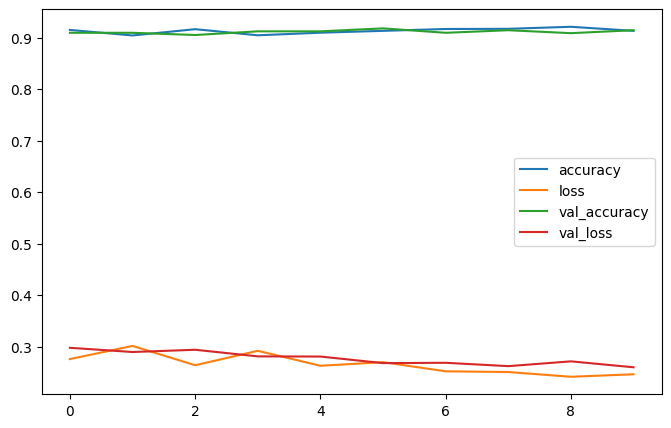

In [62]:
pd.DataFrame(history6AGStepsW.history).plot(figsize=(8,5))
plt.show()

In [ ]:
checkpoint_path = "/content/drive/MyDrive/EuroSAT/Models/Limited/checkpoint5.weights.h5"
checkpoint_callback= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, save_freq="epoch", verbose=1)

In [74]:
model_6.load_weights(checkpoint_path)
loaded_weights_model_results = model_6.evaluate(test_dataset)

 1/44 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.8125 - loss: 0.5839

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.8983 - loss: 0.3120


In [75]:
model_6_base_model=model_6.layers[2]
model_6_base_model.trainable=True
for layer in model_6_base_model.layers[:-5]:
  layer.trainable=False


In [76]:
model_6.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

In [77]:
for layer_num, layer in enumerate(model_6_base_model.layers):
  print(layer_num, layer.name, layer.trainable)

0 input_layer_10 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 con

In [78]:
print(len(model_6.trainable_variables))

6


In [79]:
fine_tune_epochs = initial_epochs + 10
history_model_6_AUG_Lpe = model_6.fit(train_dataset,epochs=fine_tune_epochs,
                          validation_data=test_dataset,
                          steps_per_epoch=steps_per_epoch,
                          initial_epoch=history6AGStepsW.epoch[-1],
                          callbacks=[ tensorflow_callback('transfer_learning', "limiteddataset_resnet50v2_6AGFineTune")])

Saving the log files to: transfer_learning/limiteddataset_resnet50v2_6AGFineTune/20240913-140804
Epoch 10/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 195ms/step - accuracy: 0.8597 - loss: 0.4530 - val_accuracy: 0.8864 - val_loss: 0.3694
Epoch 11/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - accuracy: 0.9110 - loss: 0.2659 - val_accuracy: 0.9043 - val_loss: 0.3066
Epoch 12/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 176ms/step - accuracy: 0.9164 - loss: 0.2338 - val_accuracy: 0.9179 - val_loss: 0.2562
Epoch 13/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 172ms/step - accuracy: 0.9180 - loss: 0.2477 - val_accuracy: 0.9171 - val_loss: 0.2805
Epoch 14/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 172ms/step - accuracy: 0.9214 - loss: 0.2336 - val_accuracy: 0.9200 - val_loss: 0.2603
Epoch 15/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - accuracy: 0.9214 - loss: 0.2354 - val_accuracy: 0.9186 - val_loss: 0.2984
Epoch 16/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step - accuracy: 0.9289 - loss: 0.2308 - val_accuracy: 0.9171 - val_loss: 

In [80]:
results_featureextraction_AGL2_FineTune = model_6.evaluate(test_dataset)
results_featureextraction_AGL2_FineTune

44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.9090 - loss: 0.2994


[0.2579418420791626, 0.9142857193946838]

In [81]:
def compare_history(original_history, new_history, initial_epochs=10):
  # Original history
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]
  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history with new history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]
  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Create separate plots for accuracy and loss
  plt.figure(figsize=(10,10))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Validation Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Fine Tuning Start")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  plt.subplot(2,1,2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Validation Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Fine Tuning Start")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")
  plt.xlabel("Epochs")
  plt.show()


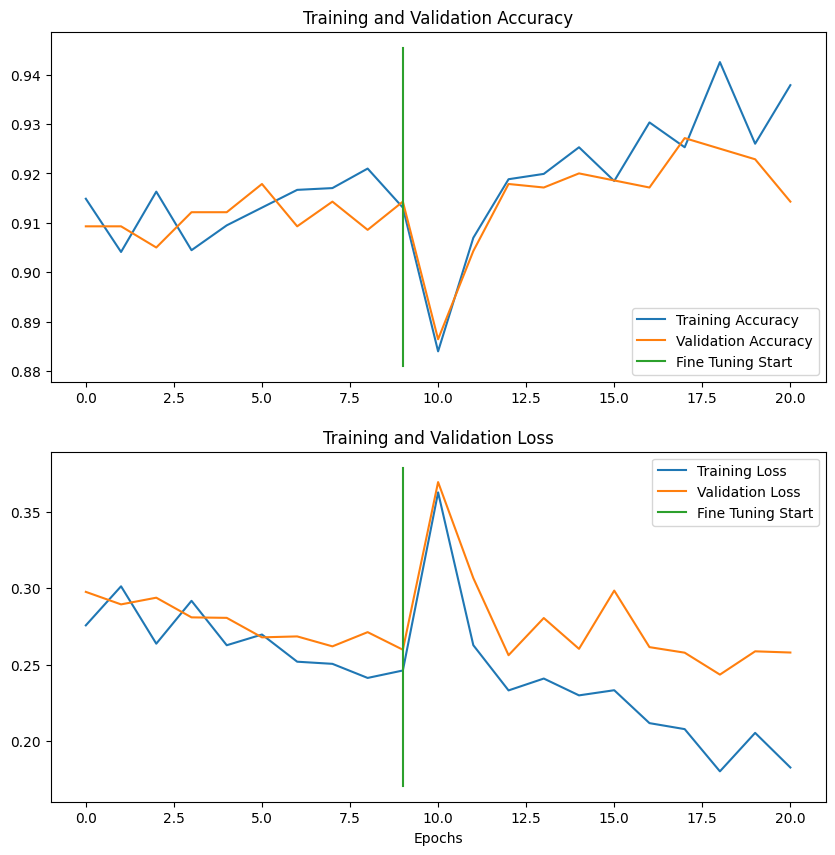

In [82]:
compare_history(original_history=history6AGStepsW,
                new_history=history_model_6_AUG_Lpe, initial_epochs=10)

In [95]:
from sklearn.metrics import classification_report, confusion_matrix
predictions = model_6.predict(test_data_limited1)
y_pred = np.argmax(predictions, axis=1)
y_true= np.concatenate([np.argmax(y, axis=1) for x,y in test_data_limited1], axis=0)
class_names= ['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']
report=classification_report(y_true, y_pred, target_names=class_names)
print(report)

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step
                      precision    recall  f1-score   support

          AnnualCrop       0.95      0.86      0.90       155
              Forest       0.96      0.96      0.96       156
HerbaceousVegetation       0.91      0.90      0.91       155
             Highway       0.83      0.92      0.87       130
          Industrial       0.96      0.93      0.95       130
             Pasture       0.79      0.92      0.85       104
       PermanentCrop       0.83      0.93      0.88       130
         Residential       0.95      0.99      0.97       155
               River       0.96      0.75      0.84       130
             SeaLake       0.99      0.95      0.97       155

            accuracy                           0.91      1400
           macro avg       0.91      0.91      0.91      1400
        weighted avg       0.92      0.91      0.91      1400



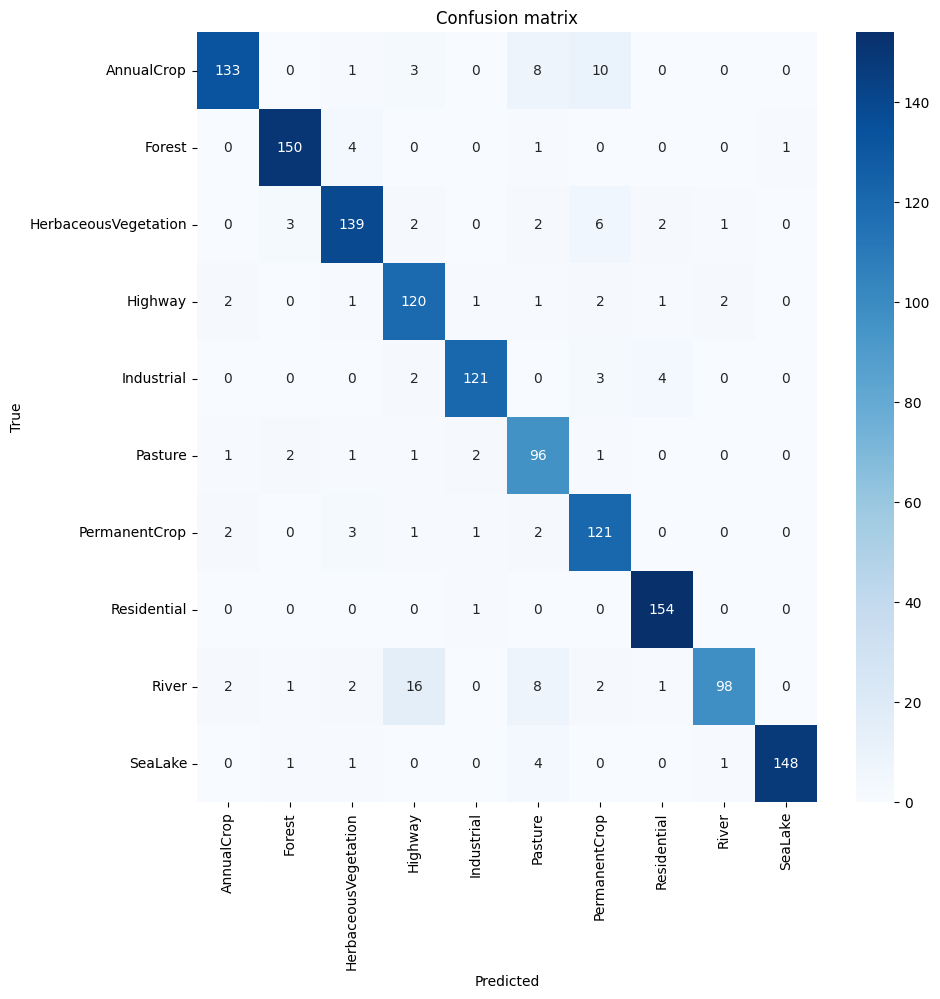

In [96]:
conf_matrix=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix")
plt.show()

# Full Dataset

## Data preparation

In [83]:
train_data_Full= tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR_F,
                                                                         shuffle=True,
                                                                         batch_size=batch_size,
                                                                         image_size=IMG_SIZE,
                                                                         label_mode='categorical'
                                                                         )
test_data_Full = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR_F,
                                                                         shuffle=False,
                                                                         image_size=IMG_SIZE,
                                                                         batch_size=batch_size,
                                                                         label_mode='categorical')

Found 21600 files belonging to 10 classes.
Found 5400 files belonging to 10 classes.


In [84]:
model_6.evaluate(test_data_Full)

169/169 ━━━━━━━━━━━━━━━━━━━━ 417s 2s/step - accuracy: 0.9233 - loss: 0.2296


[0.21250440180301666, 0.9320370554924011]

In [85]:
AUTOTUNE = tf.data.AUTOTUNE
train_data_full = train_data_Full.cache().prefetch(buffer_size=AUTOTUNE)
test_data_full = test_data_Full.cache().prefetch(buffer_size=AUTOTUNE)
train_dataset = train_data_Full
test_dataset = test_data_Full
steps_per_epoch = len(train_data_limited1) // batch_size

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255., horizontal_flip=True, vertical_flip=True, rotation_range=60,shear_range=0.2,zoom_range=0.1, height_shift_range=0.1, width_shift_range=0.1)
test_datagen = ImageDataGenerator(rescale=1/255.)
train_data_full= train_datagen.flow_from_directory(TRAIN_DIR_F,
                                                        target_size=IMG_SIZE,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        shuffle=True,
                                                        seed=42,

                                                       )
test_data_full = test_datagen.flow_from_directory(TEST_DIR_F,
                                                        target_size=IMG_SIZE,
                                                        class_mode='categorical',
                                                        shuffle=False,
                                                        batch_size=batch_size)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


## Model building

In [ ]:
model_4.evaluate(test_data_full)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


169/169 ━━━━━━━━━━━━━━━━━━━━ 3623s 22s/step - accuracy: 0.9400 - loss: 0.1849


[0.22683243453502655, 0.9259259104728699]

## Evaluation

# Another approach
I will use the data from the original dataset and split it into testing and training on random

In [ ]:
# Print class_names
class_names=np.array(sorted([item.name for item in base_dir.glob('*')]))
print(class_names)

['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']


In [ ]:
file_paths=[]
labels=[]

In [ ]:
# Create labels
for class_index, class_name in enumerate(class_names):
  class_dir=base_dir / class_name
  for file_path in class_dir.glob("*"):
    file_paths.append(str(file_path))
    labels.append(class_index)

In [ ]:
file_paths_ds = tf.data.Dataset.from_tensor_slices(file_paths)
labels_ds = tf.data.Dataset.from_tensor_slices(labels)

In [ ]:
dataset = tf.data.Dataset.zip((file_paths_ds, labels_ds))

In [ ]:
shuffled_dataset=dataset.shuffle(buffer_size=len(file_paths), reshuffle_each_iteration=False)
final_dataset = shuffled_dataset.take(NUM_IMAGES)

In [ ]:
# Create test and train
train_size= int(NUM_IMAGES*0.8)
test_size= NUM_IMAGES-train_size
train_dataset = final_dataset.take(train_size)
test_dataset = final_dataset.skip(train_size).take(test_size)

In [ ]:
print(tf.data.experimental.cardinality(train_dataset).numpy())
print(tf.data.experimental.cardinality(test_dataset).numpy())

5600
1400


In [ ]:
def decode_img(file_path):
  img = tf.io.read_file(file_path)
  img = tf.io.decode_jpeg(img, channels=3)
  return tf.image.resize(img, IMG_SIZE)

In [ ]:
def process_path(file_path, label):
  img = decode_img(file_path)
  return img, label

In [ ]:
train_dataset = train_dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
for image, label in train_dataset.take(1):
  print('Image shape:', image.numpy().shape)
  print('Label: ', label.numpy())

Image shape: (224, 224, 3)
Label:  3


In [ ]:
# Batching and shuffling the data
def configure_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size=BATCH_SIZE)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

train_dataset = configure_performance(train_dataset)
test_dataset = configure_performance(test_dataset)

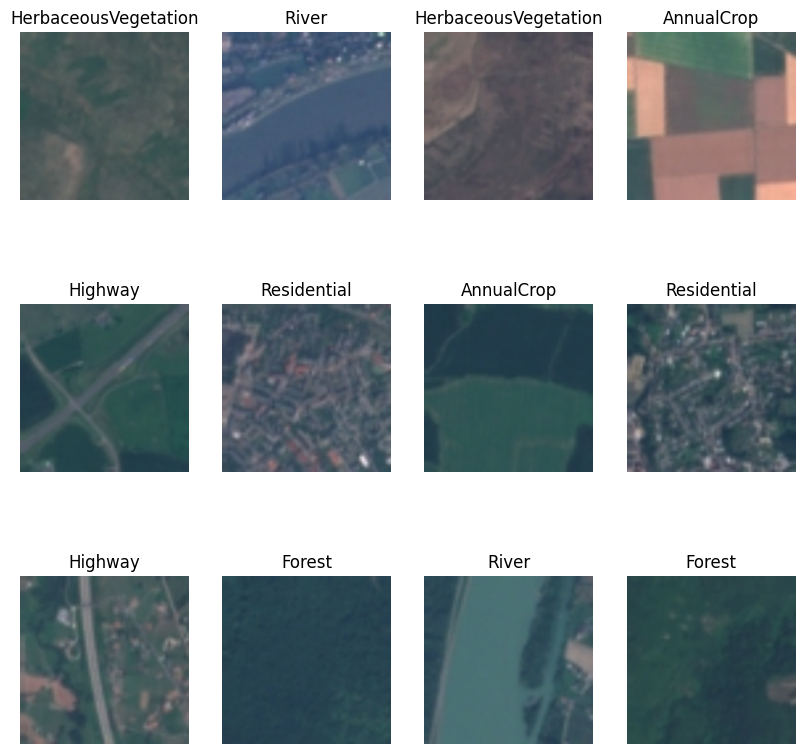

In [ ]:
image_batch, label_batch = next(iter(train_dataset))

plt.figure(figsize=(10, 10))
for i in range(12):
  ax = plt.subplot(3, 4, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [ ]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = test_size // BATCH_SIZE

In [ ]:
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable=False
# Building the model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# Normalising the data
x = tf.keras.layers.Rescaling(rescale)(inputs)

x = base_model(x)
print(f"Shape after base_model: {x.shape}")

# Average pool the outputs to reduce the computations
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling: {x.shape}")

# Add the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_00 = tf.keras.Model(inputs, outputs)

#Compiling the model
model_00.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_00 = model_00.fit(train_dataset,epochs=20,steps_per_epoch=steps_per_epoch, validation_data=test_dataset, validation_steps=validation_steps, callbacks=[tensorflow_callback('transfer_learning', "limiteddataset_resnet50_00")]).history

Shape after base_model: (None, 7, 7, 2048)
Shape after Global Average Pooling: (None, 2048)
Saving the log files to: transfer_learning/limiteddataset_resnet50_00/20240910-212921
Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 592s 3s/step - accuracy: 0.5960 - loss: 1.2844 - val_accuracy: 0.8779 - val_loss: 0.4153
Epoch 2/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9583 - val_loss: 0.2864
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.8975 - loss: 0.3481 - val_accuracy: 0.8983 - val_loss: 0.3378
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9583 - val_loss: 0.2314
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.9261 - loss: 0.2532 - val_accuracy: 0.9084 - val_loss: 0.2946
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9583 - val_loss: 0.2579
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.9400 - loss: 0.2089 - val_accuracy: 0.9099 - val_loss: 0.2772
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9583 - val_loss: 0.0924
Epoch 9/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.95